**Project for the Deep Learning course** - University of Bologna, Cesena Campus

-----------------------------------------------------------

Authors:
* Veronika Folin
* Anna Vitali
* Elena Yan

# Description of the project

-----------------------------------------------

> N.B. Sections highlighted with indentation like this are theoretical citations or references to further details inserted in order to clarify the concepts covered.

## Objective

The aim of this project is to evaluate the performance of several deep learning models on the ***Grammatical Error Correction*** (*GEC*) task, which consists to transform a potentially wrong input sentence to a corrected version.

There are different types of errors within the input text, such as spelling, punctuation, grammatical, or words.

## Dataset

The dataset used for experiments is [C4 200M Synthetic Dataset](https://huggingface.co/datasets/liweili/c4_200m), a collection of 185M sentence pairs with grammatical errors generated from [C4 (Colossal Clean Crawled Corpus)](https://www.tensorflow.org/datasets/catalog/c4?hl=it).

## Models

We tested the following models:
- **Encoder-Decoder** with **Recurrent Neural Networks**
- **Transformer**

## Optimizer

- **Adam**

  >Adam optimization is a stochastic gradient descent method based on adaptive estimation of first-order and second-order moments.

 > The method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".

- **RMSprop**

  >The gist of RMSprop is to:
  - Maintain a moving (discounted) average of the square of gradients
  - Divide the gradient by the root of this average

## Loss Functions

- **categorical_crossentropy**

  >Computes the crossentropy loss between the labels and predictions.
  Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided in a one_hot representation.

  >The shape of both y_pred and y_true are [batch_size, num_classes].

- **sparse_categorical_crossentropy**

  >Computes the crossentropy loss between the labels and predictions.
  Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided as integers.

  >The shape of y_true is [batch_size] and the shape of y_pred is [batch_size, num_classes].

## Evaluation Metrics

We used the following evaluation metrics to assess model performance:

- **Bleu**: https://huggingface.co/spaces/evaluate-metric/bleu

  >BLEU (Bilingual Evaluation Understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is".

  >Scores are calculated for individual translated segments—generally sentences—by comparing them with a set of good quality reference translations. Those scores are then averaged over the whole corpus to reach an estimate of the translation's overall quality. Neither intelligibility nor grammatical correctness are not taken into account.

  >Output Values:
  - *bleu* (float): bleu score
  - *precisions* (list of floats): geometric mean of n-gram precisions
  - *brevity_penalty* (float)
  - *length_ratio* (float)
  - *translation_length* (int)
  - *reference_length* (int)

  >BLEU’s output is always a number between 0 and 1. This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts. Few human translations will attain a score of 1, since this would indicate that the candidate is identical to one of the reference translations. For this reason, it is not necessary to attain a score of 1. Because there are more opportunities to match, adding additional reference translations will increase the BLEU score.

- **Gleu**: https://huggingface.co/spaces/evaluate-metric/google_bleu

  >The BLEU score has some undesirable properties when used for single sentences, as it was designed to be a corpus measure. The Google BLEU score is designed to limit these undesirable properties when used for single sentences.

  >To calculate this score, all sub-sequences of 1, 2, 3 or 4 tokens in output and target sequence (n-grams) are recorded. The precision and recall, described below, are then computed.

  >- *precision*: the ratio of the number of matching n-grams to the number of total n-grams in the generated output sequence
  - *recall*: the ratio of the number of matching n-grams to the number of total n-grams in the target (ground truth) sequence

  >The minimum value of precision and recall is then returned as the score.

- **Masked Accuracy**

  >Since the target sequences are padded, it is important to apply a padding mask.

# Modules import and utility functions

We check the computational resources available.

In [ ]:
!nvidia-smi

Tue Jun 13 14:00:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install and load the needed dependencies.

In [ ]:
%%capture
!pip install datasets
!pip install -q tensorflow-text
!pip install evaluate
!pip install happytransformer
!pip install accelerate -U
!pip install transformers==4.28.0

from datasets import load_dataset, Dataset, load_from_disk
from datasets import disable_caching

import pandas as pd
pd.set_option('max_colwidth', None)

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.utils import pad_sequences
from keras.layers import Input, SimpleRNN, LSTM, GRU, Embedding, Dense, TimeDistributed, Masking, Attention, Concatenate
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping
from keras.initializers import Constant

import tensorflow_text as text
from evaluate import load

bleu = load("bleu")
gleu = load("google_bleu")

from scipy.spatial import distance
import json
import re

import math

import logging
import time
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelWithLMHead
from transformers import AutoModel, AutoModelForSeq2SeqLM
from happytransformer import HappyTextToText
from happytransformer import TTSettings
from happytransformer import TTTrainArgs
from transformers import DataCollatorForSeq2Seq
from transformers import Trainer
from transformers import TrainingArguments
from transformers import pipeline

import json
import csv

disable_caching()

tf.random.set_seed(1234)

from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Deep-Learning-Project/dataset/'
project_path = '/content/drive/MyDrive/Deep-Learning-Project/'

We define the following utility functions:

- `plot_histograms` plots multiple histograms
- `plot_history` draws in a graph the loss trend over epochs on both training and validation sets. Moreover, if provided, it draws in the same graph also the trend of the given metric
- `separate_punctuation` separates words from punctuation with a space
- `generate_csv` generates CSV files with data
- `process_references` processes the targets to let them be comparable with model predictions
- `compute_metrics` computes BLEU and GLEU metrics of predictions

In [ ]:
def plot_histograms(hist_list,title_list,bins,x_label,y_label,figsize=(20,6)):
  _,axs=plt.subplots(1,len(hist_list),figsize=figsize)

  for i, hist in enumerate(hist_list):
    axs[i].set_title(title_list[i])
    axs[i].set_xlabel('# token per sentence')
    axs[i].set_ylabel('count')
    axs[i].hist(hist, bins=bins[i])


def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_xlim([1,epoch_count])
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  ax1.set_xlabel('Epochs')
  _=ax1.legend(loc='lower left')

  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],label='val_'+metric,color = line2.get_color(), linestyle = '--')
    ax2.set_ylim([0, max(max(history.history[metric]),max(history.history['val_'+metric]))])
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')


def separate_punctuation(example):
  punctuation = '!"$\'%(),.:;?'

  for elem in punctuation:
    example["input"] = example["input"].replace(elem, " " + elem + " ")
    example["output"] = example["output"].replace(elem, " " + elem + " ")
  return example


def process_references(predictions):
  punctuation = '!"$\'%(),.:;?'

  for index, elem in enumerate(predictions["output"]):
    for punct in punctuation:
      new_elem = elem.replace(elem, " " + elem + " ") # separate punctuation
    predictions["output"][index] = new_elem.lower() # lower

  return predictions


def tokenize_function(examples):
    model_inputs = tokenizer(examples["input"], padding="max_length", truncation=True)
    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["output"], padding="max_length", truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

def generate_csv(csv_path, dataset):
    with open(csv_path, 'w', newline='') as csvfile:
        writter = csv.writer(csvfile)
        writter.writerow(["input", "target"])
        for element in dataset:
     	    # Adding the task's prefix to input
            input_text = "grammar: " + element["input"]
            writter.writerow([input_text, element["output"]])


def compute_metrics(predictions):
  predictions = process_references(predictions)

  hypotheses = predictions["prediction"]
  references = predictions["output"]

  # BLEU
  bleu_result = bleu.compute(predictions=hypotheses, references=references)
  gleu_result = gleu.compute(predictions=hypotheses, references=references)

  print(bleu_result)
  print()

  # GLEU
  print(gleu_result)

# Encoder-Decoder Model with RNNs

We train and test encoder-decoder models leveraging recurrent neural networks layers, whose implementations is provided by Keras:
- [SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/)
- [GRU](https://keras.io/api/layers/recurrent_layers/gru/)
- [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/)

Furthermore, we define additional versions utilizing the following layers:
- [Attention](https://keras.io/api/layers/attention_layers/attention/)
- [Pre-trained Embedding](https://keras.io/examples/nlp/pretrained_word_embeddings/#load-pretrained-word-embeddings), like [GloVe](https://nlp.stanford.edu/projects/glove/)

## Dataset

We choose the number of examples to experiment with.

In [ ]:
dataset_size = 100000

### Loading

We load the dataset from the *HuggingFace* library, using the `load_dataset` module.

We enable the `streaming` mode because the size of the dataset exceeds the disk space of the remote machine: the data actually loaded into memory will be the ones we decide to select with the `take` method.

In [ ]:
%%capture

dataset = load_dataset("liweili/c4_200m", split="train", streaming=True)

In [ ]:
dataset_streamed = dataset.take(dataset_size)
dataset = Dataset.from_list(list(dataset_streamed))

print('Dataset size: ', dataset.num_rows)

Dataset size:  100000


We show the first 10 records.

In [ ]:
pd.DataFrame.from_dict(dataset[:10])

,input,output
0,"Bitcoin is for $7,094 this morning, which CoinDesk says.","Bitcoin goes for $7,094 this morning, according to CoinDesk."
1,The effect of widespread dud targets two face up attack position monsters on the field.,"1. The effect of ""widespread dud"" targets two face up attack position monsters on the field."
2,"tax on sales of stores for non residents are set at 21% for 2014 and 20% in 2015 payable on sales tentatively earned from the difference of the property value some time of purchase (price differences according to working time) and theyear to which sale couples (sales costs), based on the approved annual on the base approved by law).","Capital Gains tax on the sale of properties for non-residents is set at 21% for 2014 and 20% in 2015 payable on profits earned on the difference of the property value between the year of purchase (purchase price plus costs) and the year of sale (sales price minus costs), based on the approved annual percentage increase on the base value approved by law."
3,Much many brands and sellers still in the market.,Many brands and sellers still in the market.
4,this is is the latest Maintenance release of Samba 3.6,This is is the latest maintenance release of Samba 3.6.
5,"Fairy Or Not, I'm the Godmother: no just look, but my outfit for taking the part as godmother.","Fairy Or Not, I'm the Godmother: Not just a look, but my outfit for taking on the role as godmother."
6,Watcch as this Dodge Challenger Hellcat gets smoked by a Tesla Model S - with the drag strip.,Watch as this Dodge Challenger Hellcat gets smoked by a Tesla Model S at the drag strip.
7,"Momover, these devices have been proven to help consumers during another company his information.","Moreover, these devices are proven to help consumers while another company that information."
8,"Ever cloud has a silver lining and it’s just possible that we were beaten before the off as the first three home came from stalls eight to 12, while we were drawn in berth two which meant that our fellow was forced to race in the middle the course while the leader kicked on on the stands’ high rail.","Every cloud has a silver lining and it’s just possible that we were beaten before the off as the first three home came from stalls eight to 12, while we were drawn in berth two which meant that our fellow was forced to race in the middle of the course while the leader kicked on on the stands’ rail."
9,Worthless involved's supporting for the movement.,Get involved and help the movement!


### Preprocessing

#### Separate punctuation

The dataset often comprises punctuations attached to the previous or following word.

To allow the tokenizer (which we will train later) to find separate tokens for punctuation and actual words, we use the `separate_punctuation` method to separate the former from the latter.


In [ ]:
dataset = dataset.map(separate_punctuation)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Visualize the result.

In [ ]:
pd.DataFrame.from_dict(dataset).head()

,input,output
0,"Bitcoin is for $ 7 , 094 this morning , which CoinDesk says .","Bitcoin goes for $ 7 , 094 this morning , according to CoinDesk ."
1,The effect of widespread dud targets two face up attack position monsters on the field .,"1 . The effect of "" widespread dud "" targets two face up attack position monsters on the field ."
2,"tax on sales of stores for non residents are set at 21 % for 2014 and 20 % in 2015 payable on sales tentatively earned from the difference of the property value some time of purchase ( price differences according to working time ) and theyear to which sale couples ( sales costs ) , based on the approved annual on the base approved by law ) .","Capital Gains tax on the sale of properties for non-residents is set at 21 % for 2014 and 20 % in 2015 payable on profits earned on the difference of the property value between the year of purchase ( purchase price plus costs ) and the year of sale ( sales price minus costs ) , based on the approved annual percentage increase on the base value approved by law ."
3,Much many brands and sellers still in the market .,Many brands and sellers still in the market .
4,this is is the latest Maintenance release of Samba 3 . 6,This is is the latest maintenance release of Samba 3 . 6 .


#### Filter sentences by length

In this section we perform some statistics to assess that the range of the number of distinct words in the single input and output sentences is very wide.

If we kept all the examples in the dataset indistinctly and applied padding based on the length of the longest sentence, we would get a very large network size.

Managing very large arrays can become a problem if you want to adopt a solution that applies one-hot encoding (see section *One hot encoding version*) but also in one that adopts the word embedding technique.

In fact, by instantiating layers that depend on the maximum length of the input, we would inevitably force the network to have a greater number of trainable parameters that would be "superfluous" for those examples that have a much smaller number than the maximum length calculated within the dataset.

The resources available on Colab would not be enough to manage large vectors, without throwing "out of memory exception" before the end of the computation.

However, it is possible to specify to the network to ignore the padding tokens but, for the sake of simplicity, it was decided to filter the sentences within the dataset based on the maximum length that we decide to keep according to a certain criterion.

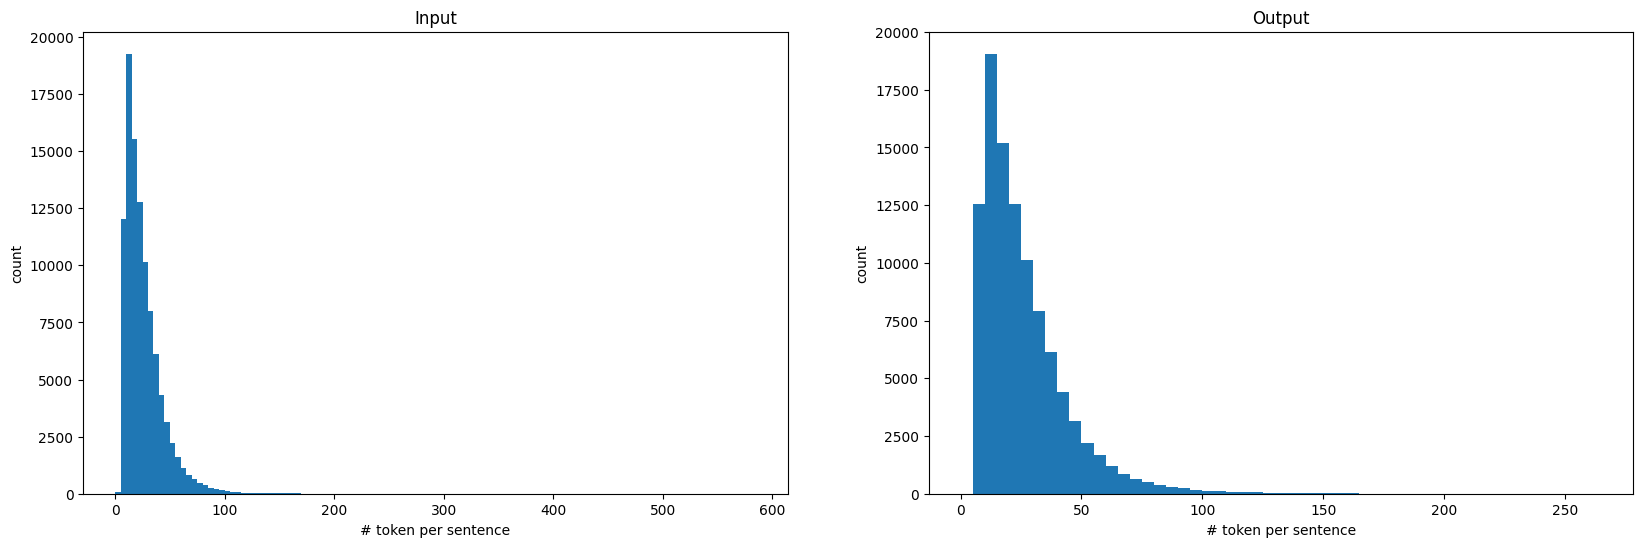

In [ ]:
len_sentences = [[len(x.split()) for x in dataset["input"]], [len(x.split()) for x in dataset["output"]]]
bins = [range(0, max(elem), 5) for elem in len_sentences]

plot_histograms(len_sentences, ['Input','Output'], bins, x_label='# token per sentence', y_label='count', figsize=(20,6))

In [ ]:
len_sentences_dataset = np.concatenate(len_sentences).ravel().tolist()
len_statistics = pd.DataFrame.from_dict(len_sentences_dataset).describe()
len_statistics

,0
count,200000.000000
mean,25.476175
std,18.621835
min,2.000000
25%,13.000000
50%,21.000000
75%,33.000000
max,586.000000


We decide to keep those examples that have at most a number of words equal to 75-th percentile of words length.

In [ ]:
mean_len = math.ceil(len_statistics.loc["75%"][0])
print("75% of the inputs in the dataset have at most " + str(mean_len) + " words.")

dataset = dataset.filter(lambda example: len(example["input"].split()) <= mean_len)
print("After filtering the dataset has " + str(dataset.num_rows) + " samples.")

Il 75% degli input nel dataset ha al massimo 33 parole.


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dopo il filtering il dataset ha 76347 elementi.


#### Split data into training, validation and test sets

In the next section we will create the tokenizer that needs to be trained on the training examples.

Therefore we proceed to the subdivision of the dataset into training, validation and test splits.

In [ ]:
dataset_splitted = dataset.train_test_split(test_size=0.2)
train_set = dataset_splitted["train"]

dataset_splitted = dataset_splitted["test"].train_test_split(test_size=0.5)
eval_set = dataset_splitted["train"]
test_set = dataset_splitted["test"]

print('Training set size: ', train_set.num_rows)
print('Validation set size: ', eval_set.num_rows)
print('Test set size: ', test_set.num_rows)

Training set size:  61077
Validation set size:  7635
Test set size:  7635


#### Text Tokenization

The tokenization phase is necessary because deep learning models are not able to process text sequences, which will have to be transformed into integer sequences.

At this stage it was decided to apply tokenization at the word level.

We instantiate a `tokenizer` that will create a dictionary of the words found in the input and target of our training set.

We also add the tokens `\t` and `\n` , which are the start and end tokens.

In [ ]:
tokenizer = Tokenizer(filters = '#&()*+-/<=>@[\\]^_`{|}~')

tokenizer_set = ["\t", "\n"] + train_set["input"] + train_set["output"]

tokenizer.fit_on_texts(tokenizer_set)

We display the first 100 elements of the created dictionary, in descending order of frequency (*frequency*), together with the assigned index within the dictionary (*index*).

The index 0 will never be assigned by the tokenizer, so we can use it to manually assign it to the padding token.

In [ ]:
dictionary = {}

dictionary["<PAD>"] = (0, None)

for word, index in tokenizer.word_index.items():
  dictionary[word] = (index, tokenizer.word_counts[word])

len_dictionary = len(dictionary)

pd.set_option('display.min_rows', 100)
pd.DataFrame.from_dict(dictionary, orient="index", columns=["index", "frequency"])

,index,frequency
<PAD>,0,NaN
.,1,127442.0
the,2,80017.0
",",3,69827.0
and,4,49878.0
to,5,49196.0
of,6,42864.0
a,7,36273.0
in,8,33123.0
for,9,23535.0


In [ ]:
print('The dictionary consists of : ' + str(len_dictionary) + " items")

Il dizionario è composto da: 88883 elementi


The `tokenize` function takes as input a sentence of a dataset split and populates 3 new columns within the split:

- `input_encoder`
- `input_decoder`, same as `output_decoder` but including start and end of sequence tokens
- `output_decoder`


The 3 new columns created will correspond to a list of dictionary index sequences assigned to the tokens of the examples present in the dataset, using the `texts_to_sequences` method.

In [ ]:
def tokenize(example):
  example["input_encoder"] = tokenizer.texts_to_sequences([example["input"]])[0]
  example["input_decoder"] = tokenizer.texts_to_sequences(["\t " + example["output"] + " \n"])[0]
  example["output_decoder"] = tokenizer.texts_to_sequences([example["output"]])[0]
  return example

train_set = train_set.map(tokenize)
eval_set = eval_set.map(tokenize)
test_set = test_set.map(tokenize)

Map:   0%|          | 0/61077 [00:00<?, ? examples/s]

Map:   0%|          | 0/7635 [00:00<?, ? examples/s]

Map:   0%|          | 0/7635 [00:00<?, ? examples/s]

We visualize the result.

In [ ]:
pd.DataFrame.from_dict(train_set).head()

,input,output,input_encoder,input_decoder,output_decoder
0,"If 70-646 Cert Exam - any order requiring immediate obedience - were contained in this , Exam Cost .","If 70-646 Cert Exam any order requiring immediate obedience were contained in this , Exam Cost .","[44, 1698, 13735, 12940, 1432, 70, 256, 6057, 2958, 20567, 97, 5897, 8, 22, 3, 1432, 407, 1]","[63640, 44, 1698, 13735, 12940, 1432, 70, 256, 6057, 2958, 20567, 97, 5897, 8, 22, 3, 1432, 407, 1, 63641]","[44, 1698, 13735, 12940, 1432, 70, 256, 6057, 2958, 20567, 97, 5897, 8, 22, 3, 1432, 407, 1]"
1,"Vitamin E is found only in your body , and they can carteriovascular health , and more .","Vitamin E is found only your body , and they can cardiovascular health , and more .","[4125, 265, 10, 275, 101, 8, 20, 432, 3, 4, 58, 32, 63642, 201, 3, 4, 42, 1]","[63640, 4125, 265, 10, 275, 101, 20, 432, 3, 4, 58, 32, 18367, 201, 3, 4, 42, 1, 63641]","[4125, 265, 10, 275, 101, 20, 432, 3, 4, 58, 32, 18367, 201, 3, 4, 42, 1]"
2,s Application for Selection to the Health Information Technology Program,Application for Selection to the Health Information Technology Program .,"[30, 374, 9, 1247, 5, 2, 201, 99, 416, 264]","[63640, 374, 9, 1247, 5, 2, 201, 99, 416, 264, 1, 63641]","[374, 9, 1247, 5, 2, 201, 99, 416, 264, 1]"
3,"A strain that was became popular in California dispensaries in 2005 , Gods Gift contains flavors of grape , citros , hash .","A strain that became popular in California dispensaries in 2005 , Gods Gift contains flavors of grape , citrus , hash .","[7, 7535, 18, 36, 1424, 853, 8, 1110, 29701, 8, 1992, 3, 6538, 768, 1374, 5514, 6, 8351, 3, 63643, 3, 10366, 1]","[63640, 7, 7535, 18, 1424, 853, 8, 1110, 29701, 8, 1992, 3, 6538, 768, 1374, 5514, 6, 8351, 3, 6519, 3, 10366, 1, 63641]","[7, 7535, 18, 1424, 853, 8, 1110, 29701, 8, 1992, 3, 6538, 768, 1374, 5514, 6, 8351, 3, 6519, 3, 10366, 1]"
4,"To be eligible to claim these tariffs ; you must be a specialist in Dermatology , Plastic Surgery or Neurology and approved by a consultant group of Doctors Manitoba .","To be eligible to claim these tariffs you must be a specialist in Dermatology , Plastic Surgery or Neurology and approved by a consultant group of Doctors Manitoba .","[5, 25, 2783, 5, 1023, 93, 9835, 66, 11, 217, 25, 7, 2120, 8, 9425, 3, 1625, 1740, 27, 16331, 4, 1643, 28, 7, 3577, 227, 6, 3730, 11529, 1]","[63640, 5, 25, 2783, 5, 1023, 93, 9835, 11, 217, 25, 7, 2120, 8, 9425, 3, 1625, 1740, 27, 16331, 4, 1643, 28, 7, 3577, 227, 6, 3730, 11529, 1, 63641]","[5, 25, 2783, 5, 1023, 93, 9835, 11, 217, 25, 7, 2120, 8, 9425, 3, 1625, 1740, 27, 16331, 4, 1643, 28, 7, 3577, 227, 6, 3730, 11529, 1]"


We display the first sequence of *input_encoder* and the corresponding original text, reconstructed using the `sequences_to_texts` method.

In [ ]:
idx=0
print(train_set[idx]["input_encoder"])
print(tokenizer.sequences_to_texts([train_set[idx]["input_encoder"]]))
print('Lunghezza della sequenza: ',len(train_set[idx]["input_encoder"]))

[44, 1698, 13735, 12940, 1432, 70, 256, 6057, 2958, 20567, 97, 5897, 8, 22, 3, 1432, 407, 1]
['if 70 646 cert exam any order requiring immediate obedience were contained in this , exam cost .']
Lunghezza della sequenza:  18


#### Padding

To take advantage of the batched mode of the training and validation phases, and therefore not to process each example individually but in batches, it is necessary to make the token sequences of the same length.

We calculate the number of tokens for each *input_encoder* and *input_decoder* of the dataset, then display the general statistics.

In [ ]:
len_sentences = [[len(x) for x in train_set["input_encoder"]],
  [len(x) for x in eval_set["input_encoder"]],
  [len(x) for x in test_set["input_encoder"]],
  [len(x) for x in train_set["input_decoder"]],
  [len(x) for x in eval_set["input_decoder"]],
  [len(x) for x in test_set["input_decoder"]]]

len_sentences_dataset = np.concatenate(len_sentences).ravel().tolist()
len_statistics = pd.DataFrame.from_dict(len_sentences_dataset).describe()
len_statistics

,0
count,152694.000000
mean,18.484891
std,7.727419
min,1.000000
25%,12.000000
50%,17.000000
75%,24.000000
max,65.000000


Before applying padding to the sequences, we calculate the average number of tokens to fix (or to add) and the percentage of errors in the input sequences of the training set.

In [ ]:
tot_errors = 0

def calculate_errors(example):
  global tot_errors
  tokens_input = example["input_encoder"]
  tokens_output = example["output_decoder"]

  errors = set(tokens_output).symmetric_difference(set(tokens_input))
  tot_errors += len(errors)

train_set.map(calculate_errors)

mean_errors = tot_errors/train_set.num_rows
mean_len = len_statistics.loc["mean"][0]
percentage_errors = mean_errors / mean_len

print("The mean of errors in train set: " + str(mean_errors))
print("The percentage of errors in train set: " + str(percentage_errors) + " %")

Map:   0%|          | 0/61077 [00:00<?, ? examples/s]

The mean of errors in train set: 4.607004273294367
The percentage of errors in train set: 0.24923080075138562 %


This calculation shows us that on average a sentence in the training set has about 4 errors and the percentage of incorrect tokens is equivalent to 24% of the total.

We use the `pad_sequences` method to make each sentence the same length: sequences that are shorter than the max_len value will have 0s added, which correspond to the index of the padding token.

In [ ]:
max_len = int(len_statistics.loc["max"][0])

def add_padding(example):
  example["input_encoder"] = pad_sequences([example["input_encoder"]], maxlen = max_len, padding = "post")[0]
  example["input_decoder"] = pad_sequences([example["input_decoder"]], maxlen = max_len, padding = "post")[0]
  example["output_decoder"] = pad_sequences([example["output_decoder"]], maxlen = max_len, padding = "post")[0]
  return example


train_set = train_set.map(add_padding)
eval_set = eval_set.map(add_padding)
test_set = test_set.map(add_padding)

Map:   0%|          | 0/61077 [00:00<?, ? examples/s]

Map:   0%|          | 0/7635 [00:00<?, ? examples/s]

Map:   0%|          | 0/7635 [00:00<?, ? examples/s]

We visualize the result.

In [ ]:
pd.DataFrame.from_dict(train_set).head()

,input,output,input_encoder,input_decoder,output_decoder
0,"If 70-646 Cert Exam - any order requiring immediate obedience - were contained in this , Exam Cost .","If 70-646 Cert Exam any order requiring immediate obedience were contained in this , Exam Cost .","[44, 1698, 13735, 12940, 1432, 70, 256, 6057, 2958, 20567, 97, 5897, 8, 22, 3, 1432, 407, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[63640, 44, 1698, 13735, 12940, 1432, 70, 256, 6057, 2958, 20567, 97, 5897, 8, 22, 3, 1432, 407, 1, 63641, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[44, 1698, 13735, 12940, 1432, 70, 256, 6057, 2958, 20567, 97, 5897, 8, 22, 3, 1432, 407, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"Vitamin E is found only in your body , and they can carteriovascular health , and more .","Vitamin E is found only your body , and they can cardiovascular health , and more .","[4125, 265, 10, 275, 101, 8, 20, 432, 3, 4, 58, 32, 63642, 201, 3, 4, 42, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[63640, 4125, 265, 10, 275, 101, 20, 432, 3, 4, 58, 32, 18367, 201, 3, 4, 42, 1, 63641, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4125, 265, 10, 275, 101, 20, 432, 3, 4, 58, 32, 18367, 201, 3, 4, 42, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,s Application for Selection to the Health Information Technology Program,Application for Selection to the Health Information Technology Program .,"[30, 374, 9, 1247, 5, 2, 201, 99, 416, 264, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[63640, 374, 9, 1247, 5, 2, 201, 99, 416, 264, 1, 63641, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[374, 9, 1247, 5, 2, 201, 99, 416, 264, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"A strain that was became popular in California dispensaries in 2005 , Gods Gift contains flavors of grape , citros , hash .","A strain that became popular in California dispensaries in 2005 , Gods Gift contains flavors of grape , citrus , hash .","[7, 7535, 18, 36, 1424, 853, 8, 1110, 29701, 8, 1992, 3, 6538, 768, 1374, 5514, 6, 8351, 3, 63643, 3, 10366, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[63640, 7, 7535, 18, 1424, 853, 8, 1110, 29701, 8, 1992, 3, 6538, 768, 1374, 5514, 6, 8351, 3, 6519, 3, 10366, 1, 63641, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[7, 7535, 18, 1424, 853, 8, 1110, 29701, 8, 1992, 3, 6538, 768, 1374, 5514, 6, 8351, 3, 6519, 3, 10366, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"To be eligible to claim these tariffs ; you must be a specialist in Dermatology , Plastic Surgery or Neurology and approved by a consultant group of Doctors Manitoba .","To be eligible to claim these tariffs you must be a specialist in Dermatology , Plastic Surgery or Neurology and approved by a consultant group of Doctors Manitoba .","[5, 25, 2783, 5, 1023, 93, 9835, 66, 11, 217, 25, 7, 2120, 8, 9425, 3, 162

### Save pre-processing result

We save the processed dataset in Google Drive.

In [ ]:
train_set.save_to_disk(dataset_path + 'train/')
eval_set.save_to_disk(dataset_path + 'validation/')
test_set.save_to_disk(dataset_path + 'test/')

dataset_dict = {"splits": ["train", "validation", "test"]}

with open(dataset_path + 'dataset_dict.json', 'w') as f:
    json.dump(dataset_dict, f)

Saving the dataset (0/1 shards):   0%|          | 0/61077 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7635 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7635 [00:00<?, ? examples/s]

We save the *max_len* and *len_dictionary* values in a file.

In [ ]:
dataset_info = {
    "max_len": max_len,
    "len_dictionary": len_dictionary
}

with open(dataset_path + 'dataset_info.json', 'w') as f:
    json.dump(dataset_info, f, default=str)

We save the tokenizer configuration in a file.

In [ ]:
tokenizer_json = tokenizer.to_json()
with open(project_path + 'tokenizer.json', 'w', encoding='utf-8') as f:
    json.dump(tokenizer_json, f, ensure_ascii=False)

Let's save the dictionary to a file.

In [ ]:
with open(project_path + 'dictionary.json', 'w') as f:
    json.dump(dictionary, f)

### Load pre-processing result

We load the dataset and saved values from Google Drive.

In [ ]:
dataset = load_from_disk(dataset_path)
train_set = dataset["train"]
eval_set = dataset["validation"]
test_set = dataset["test"]

with open(dataset_path + 'dataset_info.json', 'r') as f:
  data = json.load(f)
  max_len = int(data["max_len"])
  len_dictionary = int(data["len_dictionary"])

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'input_encoder', 'input_decoder', 'output_decoder'],
        num_rows: 61077
    })
    validation: Dataset({
        features: ['input', 'output', 'input_encoder', 'input_decoder', 'output_decoder'],
        num_rows: 7635
    })
    test: Dataset({
        features: ['input', 'output', 'input_encoder', 'input_decoder', 'output_decoder'],
        num_rows: 7635
    })
})

In [ ]:
print(max_len, len_dictionary)

65 88883


Let's load the tokenizer configurations and verify that it works.

In [ ]:
with open(project_path + 'tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

idx=0
print(train_set[idx]["input_encoder"])
print(tokenizer.sequences_to_texts([train_set[idx]["input_encoder"]]))
print('Length of the sequence: ',len(train_set[idx]["input_encoder"]))

[44, 1698, 13735, 12940, 1432, 70, 256, 6057, 2958, 20567, 97, 5897, 8, 22, 3, 1432, 407, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['if 70 646 cert exam any order requiring immediate obedience were contained in this , exam cost .']
Lunghezza della sequenza:  65


We load the dictionary and display it.

In [ ]:
with open(project_path + 'dictionary.json', 'r') as f:
  dictionary = json.load(f)

pd.DataFrame.from_dict(dictionary, orient="index", columns=["index", "frequency"]).head()

,index,frequency
<PAD>,0,NaN
.,1,127442.0
the,2,80017.0
",",3,69827.0
and,4,49878.0


## One hot encoding version

In this section we want to train an encoder-decoder network by passing as input the one-hot encoding of the individual tokens, with respect to the elements of the dictionary.

### Setup

The `one_hot_encoding` function takes a split of the dataset as input and for each column between input_encoder, input_decoder, output_decoder a three-dimensional matrix is created with shape *(number of examples in the dataset, maximum length of the input sequence, length of the dictionary)*.

Therefore, for each sequence in the dataset and for each token of it, a vector is produced with a number of elements equal to the number of words present in the dictionary.

The position in the vector that corresponds to the index in the dictionary of the current token will be set to 1, while the others will be set to 0.

In [ ]:
def one_hot_encoding(dataset, splitName):
  print("\n ----- Start one hot encoding process for " + splitName + " split -----")
  one_hot_dataset = {}
  for column in ("input_encoder", "input_decoder", "output_decoder"):
    column_data = dataset[column]
    one_hot_column = np.zeros((len(dataset), max_len, len_dictionary), dtype="int8")
    for sentence_pos, sentence in enumerate(column_data):
      for token_pos, token_idx in enumerate(sentence):
        one_hot_column[sentence_pos, token_pos, token_idx] = 1
    one_hot_dataset[column] = tf.Variable(one_hot_column) # spostiamo la matrice tridimensionale sulla GPU
  return one_hot_dataset

one_hot_train = one_hot_encoding(train_set, "train")
one_hot_val = one_hot_encoding(eval_set, "validation")

We verify the shape of the one hot encoding produced for the training set.

In [ ]:
for column in ("input_encoder", "input_decoder", "output_decoder"):
  print("\n Shape of one hot encoding of column " + column + " on training set: " + str(one_hot_train[column].shape))


 Shape of one hot encoding of column input_encoder on training set: (2426, 65, 10915)

 Shape of one hot encoding of column input_decoder on training set: (2426, 65, 10915)

 Shape of one hot encoding of column output_decoder on training set: (2426, 65, 10915)


We extract the columns corresponding to the inputs and outputs of encoders and decoders, for the training and validation phases that we will carry out later.

In [ ]:
encoder_input_data = one_hot_train["input_encoder"]
decoder_input_data = one_hot_train["input_decoder"]
decoder_output_data = one_hot_train["output_decoder"]

cv_encoder_input_data = one_hot_val["input_encoder"]
cv_decoder_input_data = one_hot_val["input_decoder"]
cv_decoder_output_data = one_hot_val["output_decoder"]

### GRU

To test this solution we decided to use an Encoder-Decoder that uses recurring layers of the GRU type.

#### Model

We define the model by choosing a value for the `units` parameter, which corresponds to the dimensionality of the output space of the GRU layers.

In [ ]:
n_units = 300

In [ ]:
encoder_inputs = Input(shape=(None, len_dictionary))
encoder = GRU(units=n_units, return_state=True)
encoder_outputs, encoder_states = encoder(encoder_inputs)

decoder_inputs = Input(shape=(None, len_dictionary))
decoder = GRU(units=n_units, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(len_dictionary, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, None, 10915  0           []                               
                                )]                                                                
                                                                                                  
 input_29 (InputLayer)          [(None, None, 10915  0           []                               
                                )]                                                                
                                                                                                  
 gru_27 (GRU)                   [(None, 300),        10095300    ['input_28[0][0]']               
                                 (None, 300)]                                               

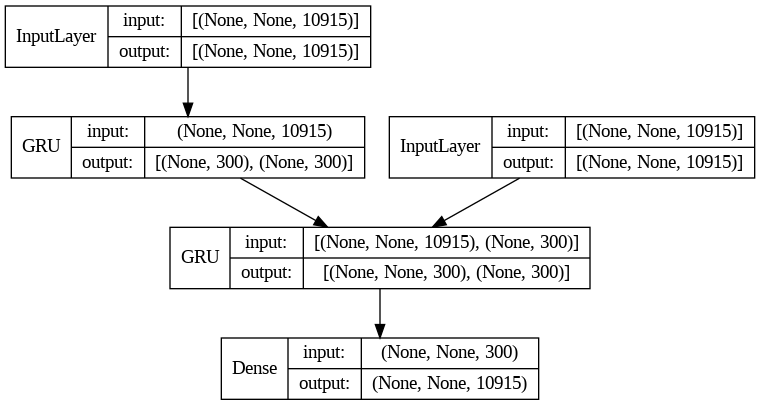

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

#### Training

In [ ]:
epoch_count = 20
batch_size = 16
patience = 5

early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_data=([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data),batch_size=batch_size,epochs=epoch_count, callbacks=[early_stop])

### Limits of the solution

One hot encoding produces a matrix with shape *(number of examples in the dataset, maximum length of the input sequence, length of the dictionary)*.

This type of solution is applicable only if one or more of these three dimensions does not reach high dimensionality.

In our case we have a very large number of words in the dictionary and, as the training examples increase, the RAM memory is saturated and the training of the network does not finish correctly.

## Word embedding version

This solution allows us to represent the different tokens as vectors in a space of predefined size, requiring less memory than One Hot encoding.

In addition, the Embedding layer is a trainable layer. Therefore, during training, the weights of this layer are changed so that it is possible to more efficiently arrange the tokens within the multi-dimensional space.

### Setup

We extract the columns corresponding to the inputs and outputs of encoders and decoders, for the training, validation, and testing phases that we will perform later.

In [ ]:
encoder_input_data = np.array(train_set["input_encoder"])
decoder_input_data = np.array(train_set["input_decoder"])
decoder_output_data = np.array(train_set["output_decoder"])

cv_encoder_input_data = np.array(eval_set["input_encoder"])
cv_decoder_input_data = np.array(eval_set["input_decoder"])
cv_decoder_output_data = np.array(eval_set["output_decoder"])

test_encoder_input_data = np.array(test_set["input_encoder"])
test_decoder_input_data = np.array(test_set["input_decoder"])
test_decoder_output_data = np.array(test_set["output_decoder"])

### Simple RNN

> SimpleRNN is a fully-connected RNN where the output is to be fed back to input.

#### Model

The model consists of an Encoder, a Decoder and an output layer.

The Encoder consists of:

- an `Input` layer
- an `Embedding` layer
- a `SimpleRNN` layer

The Decoder consists of:

- an `Input` layer
- an `Embedding` layer
- a `SimpleRNN` layer

The Output layer consists of:

- a `TimeDistributed` layer, which returns a probability distribution over the entire dictionary.

In order to mask padding tokens, we set the `mask_zero` parameter to True in the `Embedding` layers of Encoder and Decoder, as well as introduce a `Masking` layer before the output layer.

The value of `embedding_dim` defines the size of the vectors representing the tokens in the multidimensional space.

`n_units` represents the dimensionality of the output of the Encoder and Decoder components.

`input_length` is the length of the input tokens.

In [ ]:
model_path = project_path + "models/SimpleRNN"

embedding_dim = 768
n_units = 300
input_length = max_len

In [ ]:
encoder_inputs = Input(shape=(input_length, ), name="encoder_inputs")
enc_emb_layer = Embedding(input_dim = len_dictionary, output_dim = embedding_dim, input_length = input_length, trainable = True, mask_zero=True, name="encoder_embedding")
enc_emb = enc_emb_layer(encoder_inputs)

encoder = SimpleRNN(n_units, return_sequences=True, return_state=True, name="encoder")
encoder_outputs, state_h = encoder(enc_emb)

decoder_inputs = Input(shape=(input_length, ), name="decoder_inputs")
dec_emb_layer = Embedding(input_dim = len_dictionary, output_dim = embedding_dim, input_length = input_length, trainable=True, mask_zero=True, name="decoder_embedding")
dec_emb = dec_emb_layer(decoder_inputs)

decoder = SimpleRNN(n_units, return_sequences=True, return_state=True, name="decoder")
(decoder_outputs, _ ) = decoder(dec_emb, initial_state=state_h)

masking_layer = Masking(name="masking_layer")

decoder_dense = TimeDistributed(Dense(len_dictionary, activation="softmax"), name="decoder_dense")
decoder_outputs = decoder_dense(masking_layer(decoder_outputs))

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 65, 768)      68404224    ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embedding (Embedding)  (None, 65, 768)      68404224    ['decoder_inputs[0][0]']         
                                                                                              

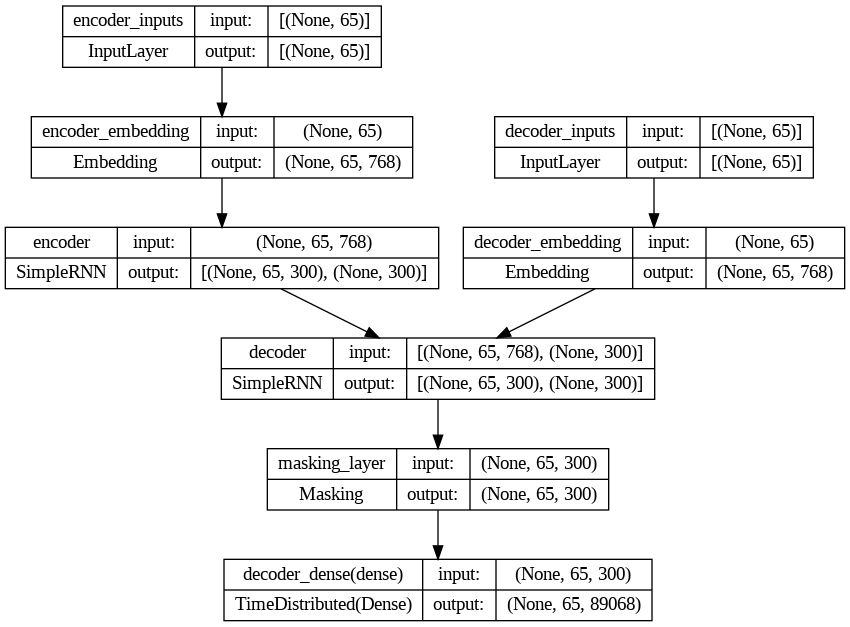

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

#### Model  (with Attention)

In order to improve the performance of the previously tested network, it was decided to introduce an `Attention` layer, i.e., a mechanism to capture the meaning of a sequence of words by "paying attention" and appropriately shifting the focus to the relationships and concepts they produce by combining with each other.

The result of this layer will be concatenated to the output of the Decoder component and, finally, will be passed to the output layer which will return, once again, a probability distribution over the dictionary.

In this case, there will be no need for a `Masking` layer before the output layer since the `Attention` and `Concatenate` layers do not transform the vector representation they receive as input, so the padding tokens remain masked.

In [ ]:
model_path = project_path + "models/SimpleRNN_Attention"

embedding_dim = 768
n_units = 300
input_length = max_len

In [ ]:
encoder_inputs = Input(shape=(input_length, ), name="encoder_inputs")
enc_emb_layer = Embedding(input_dim = len_dictionary, output_dim = embedding_dim, input_length = input_length, trainable = True, mask_zero=True, name="encoder_embedding")
enc_emb = enc_emb_layer(encoder_inputs)

encoder = SimpleRNN(n_units, return_sequences=True, return_state=True, name="encoder")
encoder_outputs, state_h = encoder(enc_emb)

decoder_inputs = Input(shape=(input_length, ), name="decoder_inputs")
dec_emb_layer = Embedding(input_dim = len_dictionary, output_dim = embedding_dim, input_length = input_length, trainable=True, mask_zero=True, name="decoder_embedding")
dec_emb = dec_emb_layer(decoder_inputs)

decoder = SimpleRNN(n_units, return_sequences=True, return_state=True, name="decoder")
(decoder_outputs, _ ) = decoder(dec_emb, initial_state=state_h)

masking_layer = Masking(name="masking_layer")

attn_layer = Attention(name='attention_layer')
attn_out = attn_layer([masking_layer(encoder_outputs), masking_layer(decoder_outputs)], training=True)
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense = TimeDistributed(Dense(len_dictionary, activation="softmax"), name="decoder_dense")
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 65, 768)      68396544    ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embedding (Embedding)  (None, 65, 768)      68396544    ['decoder_inputs[0][0]']         
                                                                                              

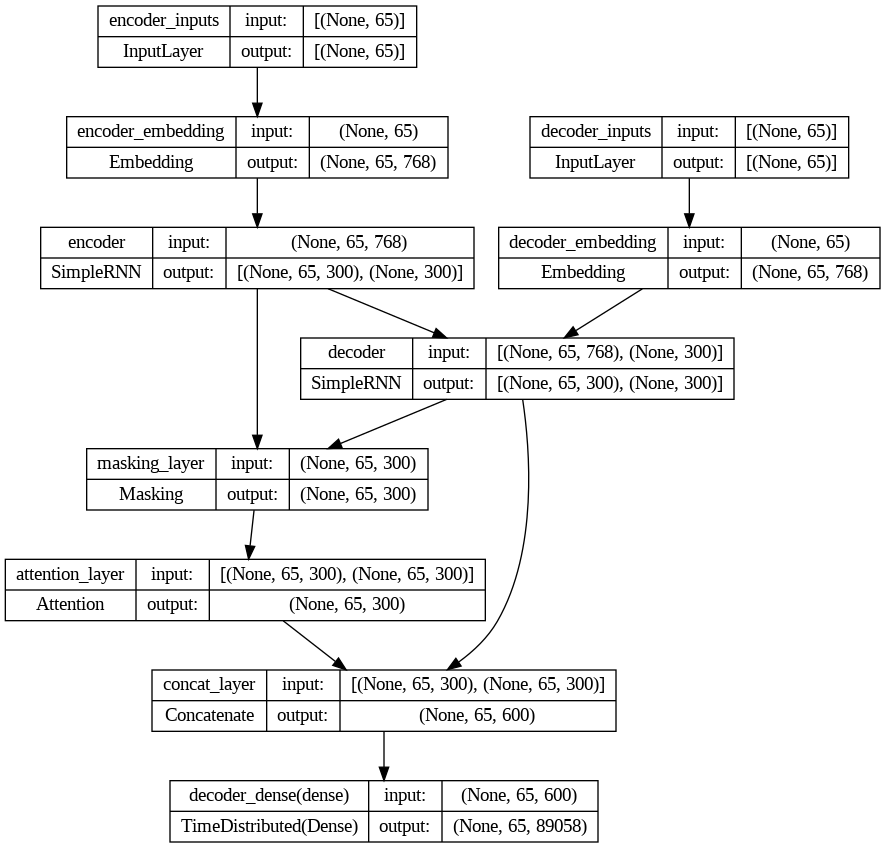

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

#### Training

In [ ]:
epoch_count = 20
batch_size = 100
patience = 2

early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [ ]:
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_data=([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data),batch_size=batch_size,epochs=epoch_count, callbacks=[early_stop])

Epoch 1/20
7/7 [==============================] - 14s 652ms/step - loss: 7.9458 - val_loss: 6.1480
Epoch 2/20
7/7 [==============================] - 4s 607ms/step - loss: 6.5720 - val_loss: 5.6775
Epoch 3/20
7/7 [==============================] - 4s 581ms/step - loss: 6.4296 - val_loss: 5.7370
Epoch 4/20
7/7 [==============================] - 4s 493ms/step - loss: 6.3347 - val_loss: 5.6409
Epoch 5/20
7/7 [==============================] - 3s 481ms/step - loss: 6.2625 - val_loss: 6.1159
Epoch 6/20
7/7 [==============================] - 4s 653ms/step - loss: 6.4522 - val_loss: 5.6414


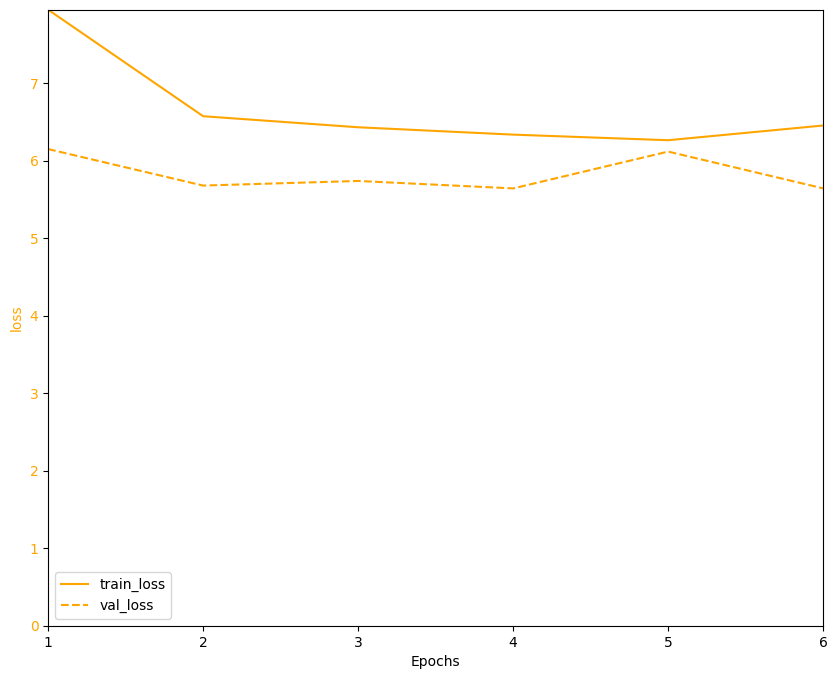

In [ ]:
plot_history(history)

#### Performance evaluation

We test the performance of the previously trained model.

In [ ]:
results = model.evaluate([test_encoder_input_data, test_decoder_input_data],test_decoder_output_data, batch_size = batch_size, verbose=0)
print('Loss: {:.3f}'.format(results))

Loss: 5.613


Save the pre-trained model.

In [ ]:
model.save(model_path)

#### Inference model

We define the same model used for training but for the inference phase.

**Inference encoder-decoder**

In [ ]:
# encoder
encoder_model = Model(inputs=encoder_inputs, outputs=(encoder_outputs, state_h))

# decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_hidden_state_input = Input(shape=(input_length, n_units))

dec_emb = dec_emb_layer(decoder_inputs)

(decoder_outputs, state_h_decoder) = decoder(dec_emb, initial_state=decoder_state_input_h)

masking_layer = Masking()
decoder_outputs = decoder_dense(masking_layer(decoder_outputs))

decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h], [decoder_outputs] + [state_h_decoder])

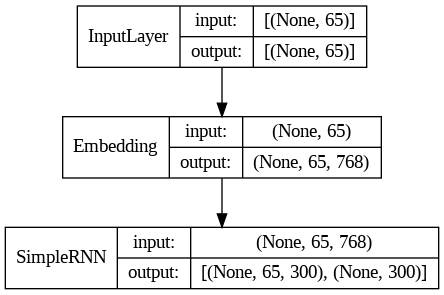

In [ ]:
keras.utils.plot_model(encoder_model, show_shapes = True, show_layer_names=False)

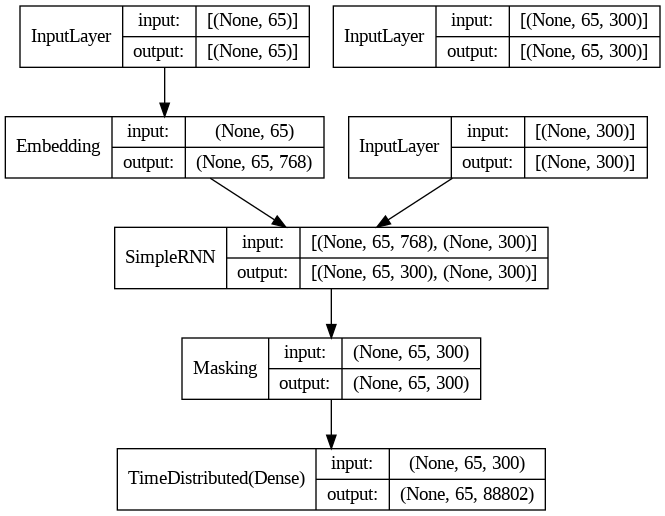

In [ ]:
keras.utils.plot_model(decoder_model, show_shapes = True, show_layer_names=False)

**Inference encoder-decoder from loaded model**

We reconstruct the encoder and decoder for the inference step, starting from the pre-trained model uploaded from Google Drive.

In [ ]:
# loaded_model = load_model(model_path)

In [ ]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 65, 768)      23943168    ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embedding (Embedding)  (None, 65, 768)      23943168    ['decoder_inputs[0][0]']         
                                                                                              

In [ ]:
# encoder
encoder_inputs = loaded_model.get_layer("encoder_inputs").input
encoder_outputs = loaded_model.get_layer("encoder").output[0]
state_h = loaded_model.get_layer("encoder").output[1]

encoder_model = Model(inputs=encoder_inputs, outputs=(encoder_outputs, state_h))

# decoder
dec_emb_layer = loaded_model.get_layer("decoder_embedding")
decoder_inputs = loaded_model.get_layer("decoder_inputs").input
decoder = loaded_model.get_layer("decoder")
decoder_dense = loaded_model.get_layer("decoder_dense")

decoder_state_input_h = Input(shape=(n_units,))
decoder_hidden_state_input = Input(shape=(input_length, n_units))

dec_emb = dec_emb_layer(decoder_inputs)

(decoder_outputs, state_h_decoder) = decoder(dec_emb, initial_state=decoder_state_input_h)

masking_layer = Masking()
decoder_outputs = decoder_dense(masking_layer(decoder_outputs))

decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h], [decoder_outputs] + [state_h_decoder])

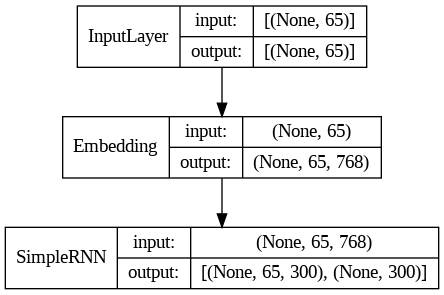

In [ ]:
keras.utils.plot_model(encoder_model, show_shapes = True, show_layer_names=False)

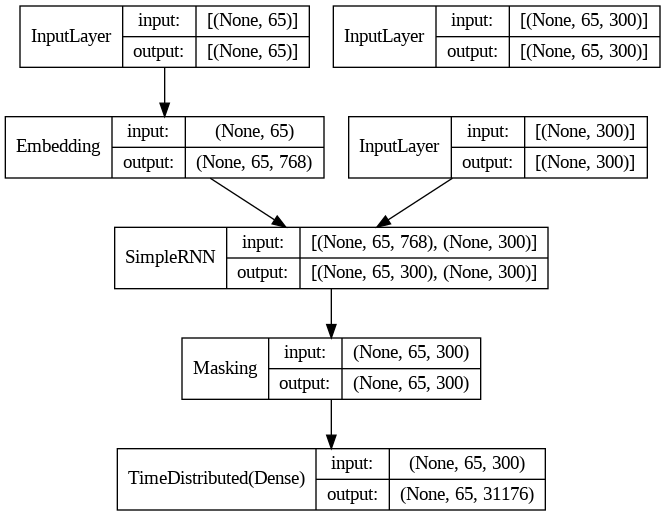

In [ ]:
keras.utils.plot_model(decoder_model, show_shapes = True, show_layer_names=False)

#### Inference Model (with Attention)

We define the model enriched by the Attention layer for the inference step.

**Inference encoder-decoder**

In [ ]:
# encoder
encoder_model = Model(inputs=encoder_inputs, outputs=(encoder_outputs, state_h))

# decoder
decoder_state_input_h = Input(shape=(n_units,)) # state_h
decoder_hidden_state_input = Input(shape=(input_length, n_units)) # encoder_outputs

dec_emb = dec_emb_layer(decoder_inputs)

(decoder_outputs, state_h_decoder) = decoder(dec_emb, initial_state=decoder_state_input_h)

masking_layer = Masking(name="masking_layer")

attn_out = attn_layer([masking_layer(decoder_hidden_state_input), masking_layer(decoder_outputs)])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_outputs = decoder_dense(decoder_concat_input)

decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h], [decoder_outputs] + [state_h_decoder])

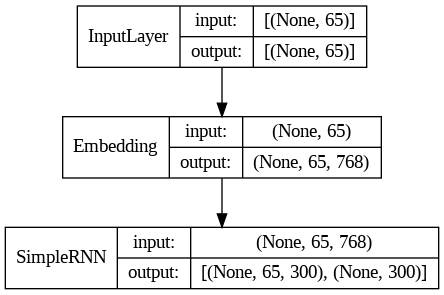

In [ ]:
keras.utils.plot_model(encoder_model, show_shapes = True, show_layer_names=False)

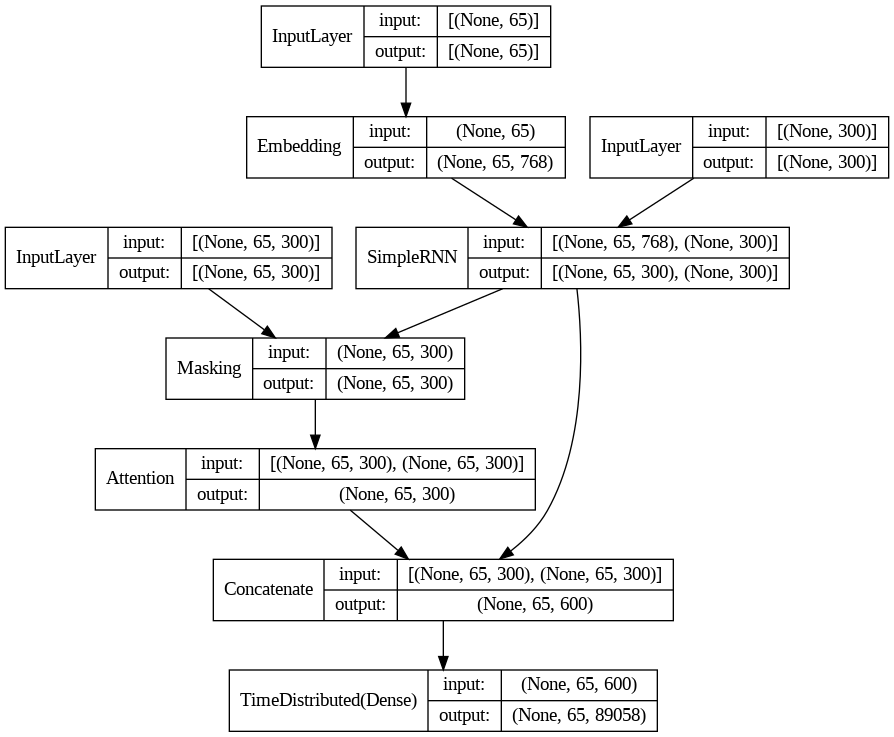

In [ ]:
keras.utils.plot_model(decoder_model, show_shapes = True, show_layer_names=False)

**Inference encoder-decoder from loaded model**

We reconstruct the encoder and decoder for the inference step, starting from the pre-trained model uploaded from Google Drive.

In [ ]:
# loaded_model = load_model(model_path)

In [ ]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 65, 768)      68396544    ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embedding (Embedding)  (None, 65, 768)      68396544    ['decoder_inputs[0][0]']         
                                                                                              

In [ ]:
# encoder
encoder_inputs = loaded_model.get_layer("encoder_inputs").input
encoder_outputs = loaded_model.get_layer("encoder").output[0]
state_h = loaded_model.get_layer("encoder").output[1]

encoder_model = Model(inputs=encoder_inputs, outputs=(encoder_outputs, state_h))

# decoder
dec_emb_layer = loaded_model.get_layer("decoder_embedding")
decoder_inputs = loaded_model.get_layer("decoder_inputs").input
decoder = loaded_model.get_layer("decoder")
attn_layer = loaded_model.get_layer("attention_layer")
decoder_dense = loaded_model.get_layer("decoder_dense")

decoder_state_input_h = Input(shape=(n_units,))
decoder_hidden_state_input = Input(shape=(input_length, n_units))

dec_emb = dec_emb_layer(decoder_inputs)

(decoder_outputs, state_h_decoder) = decoder(dec_emb, initial_state=decoder_state_input_h)

masking_layer = Masking(name="masking_layer")

attn_out = attn_layer([masking_layer(decoder_hidden_state_input), masking_layer(decoder_outputs)])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_outputs = decoder_dense(decoder_concat_input)

decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h], [decoder_outputs] + [state_h_decoder])

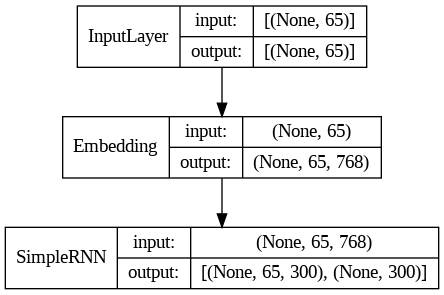

In [ ]:
keras.utils.plot_model(encoder_model, show_shapes = True, show_layer_names=False)

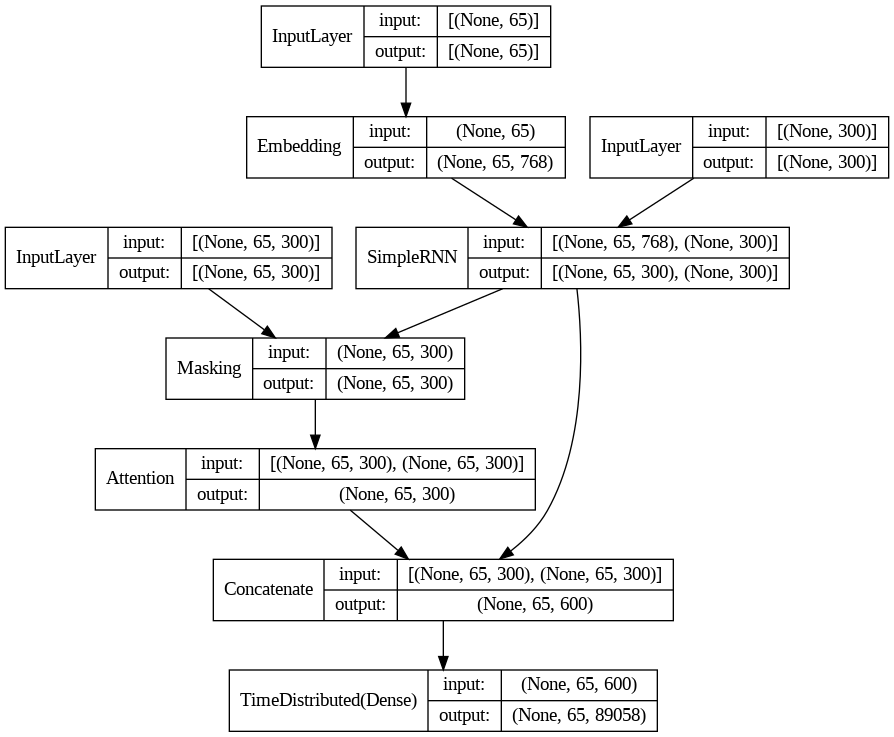

In [ ]:
keras.utils.plot_model(decoder_model, show_shapes = True, show_layer_names=False)

#### Visualize predictions

Now we want to visualize the model's predictions.

The `generate_prediction` method takes as input an *input_encoder* sequence of the testing split and reproduces the inference step by calling the components defined in the previous section.

In [ ]:
def generate_prediction(input_seq):

  # Encode the input as state vectors
  e_out, e_h = encoder_model.predict(input_seq.reshape(1, input_length))

  # Generate empty target sequence
  target_seq = np.zeros((1, 1))

  # Populate the first word of target sequence with the start word.
  target_seq[0, 0] = dictionary['\t'][0]

  stop_condition = False
  decoded_sentence = ''

  while not stop_condition:
    output_tokens, h = decoder_model.predict((target_seq, e_out, e_h))

    # Sample the token with maximum probability
    sampled_token_index = np.argmax(output_tokens[0, -1, :])

    sampled_token = tokenizer.sequences_to_texts([[sampled_token_index]])[0]

    if sampled_token != '\n':
      decoded_sentence += ' ' + sampled_token

    # Exit condition: either hit max length or find the stop word
    if sampled_token == '\n' or len(decoded_sentence.split()) > max_len:
      stop_condition = True

    # Update the target sequence
    target_seq = np.zeros((1, 1))
    target_seq[0,0] = sampled_token_index

    # Update internal states
    e_h = h

  return decoded_sentence

We choose to compute the predictions for the first `n_predictions` testing examples.

In [ ]:
%%capture

n_predictions = 100
predictions = {}

for i in range(n_predictions):
  input = test_set[i]["input"]
  output = test_set[i]["output"]
  input_seq = test_encoder_input_data[i]
  prediction = generate_prediction(input_seq)
  predictions[i] = (input, output, prediction)

In [ ]:
predictions = pd.DataFrame.from_dict(predictions, orient="index", columns=["input", "output", "prediction"])
predictions.head()

,input,output,prediction
0,A ' Memory ' is a written instrument that documents a debt and constitutes a promise to repay . . .,A ' note ' is a written instrument that evidences a debt and constitutes a promise to repay .,"a new york , the first of the first of the world , the first of the world . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m"
1,"This has all the elements of a movie that comic book fans characters should be mounted underboard , and they have been .","This has all the elements of a movie that comic book fans should be lining up for , and they have been .","this is a great , you can be a good to the next time , i ' m a good . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i"
2,Nursing program faculty will test each transfer application and transcripts on an individual basis to determine acceptanuce on a space-avaibality .,Nursing program faculty will assess each transfer application and transcripts on an individual basis to determine acceptance on a space-availability .,"the new york , the first of the first of the world , the first of the world . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m"
3,The sectors we operate are inuternationally international and have acquired good long term prospects and we plan to increase our footprint among them .,The sectors we operate in are international and have good long-term growth prospects and we plan to increase our footprint in them .,the first time is a great of the most of the most of the most of the most of the world . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m .
4,Improves audio balance of some of UI audio cues to avoid them being too loud like the combat drums . .,Improved the audio balance of some UI audio cues to avoid them being too loud ( like the combat drums ) .,"the previous post is a good , but i ' m a good to the next year . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m . i ' m ."


#### Compute metrics

We calculate the values of the BLEU and GLEU metrics on the newly generated predictions.

In [ ]:
compute_metrics(predictions)

### GRU

In this section, a network similar to the one defined in the previous section is implemented but, in this case, the Encoder and Decoder components will consist of a GRU-type recurrent network.

#### Model

In [ ]:
model_path = project_path + "models/GRU_1"

embedding_dim = 768
n_units = 300
input_length = max_len

In [ ]:
encoder_inputs = Input(shape=(input_length, ), name="encoder_inputs")
enc_emb_layer = Embedding(input_dim = len_dictionary, output_dim = embedding_dim, input_length = input_length, trainable = True, mask_zero=True, name="encoder_embedding")
enc_emb = enc_emb_layer(encoder_inputs)

encoder = GRU(n_units, return_sequences=True, return_state=True, name="encoder", dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h = encoder(enc_emb)

decoder_inputs = Input(shape=(input_length, ), name="decoder_inputs")
dec_emb_layer = Embedding(input_dim = len_dictionary, output_dim = embedding_dim, input_length = input_length, trainable=True, mask_zero=True, name="decoder_embedding")
dec_emb = dec_emb_layer(decoder_inputs)

decoder = GRU(n_units, return_sequences=True, return_state=True, name="decoder", dropout=0.4, recurrent_dropout=0.2)
(decoder_outputs, _ ) = decoder(dec_emb, initial_state=state_h)

decoder_dense = TimeDistributed(Dense(len_dictionary, activation="softmax"), name="decoder_dense")
masking_layer = Masking(name="masking_decoder")
decoder_outputs = decoder_dense(masking_layer(decoder_outputs))

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 65, 768)      68396544    ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embedding (Embedding)  (None, 65, 768)      68396544    ['decoder_inputs[0][0]']         
                                                                                              

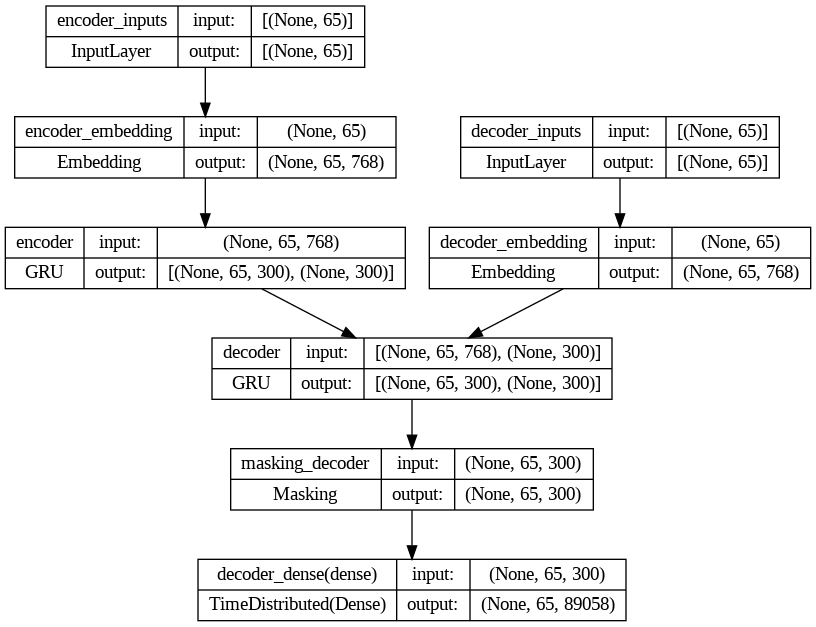

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

#### Model (with pre-trained Embedding)

We define an Encoder-Decoder model that exploits a pre-trained Embedding layer.


**Get pre-trained embedding data**

We download the data for the pre-trained embedding layer.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-06-03 07:32:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-06-03 07:32:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-03 07:32:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

he archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. We'll use the 300D ones.

In [ ]:
path_to_glove_file = os.path.join(
    "glove.6B.300d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [ ]:
num_tokens = len_dictionary
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[index] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 52945 words (35982 misses)


**Model definition**

In [ ]:
model_path = project_path + "models/GRU_pre-trained"

n_units = 100
input_length = max_len

In [ ]:
encoder_inputs = Input(shape=(input_length, ), name="encoder_inputs")
enc_emb_layer = Embedding(input_dim = len_dictionary, output_dim = embedding_dim, input_length = input_length, embeddings_initializer=Constant(embedding_matrix), trainable = False, mask_zero=True, name="encoder_embedding")
enc_emb = enc_emb_layer(encoder_inputs)

encoder = GRU(n_units, return_sequences=True, return_state=True, name="encoder", dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h = encoder(enc_emb)

decoder_inputs = Input(shape=(input_length, ), name="decoder_inputs")
dec_emb_layer = Embedding(input_dim = len_dictionary, output_dim = embedding_dim, input_length = input_length, embeddings_initializer=Constant(embedding_matrix), trainable = False, mask_zero=True, name="decoder_embedding")
dec_emb = dec_emb_layer(decoder_inputs)

decoder = GRU(n_units, return_sequences=True, return_state=True, name="decoder", dropout=0.4, recurrent_dropout=0.2)
(decoder_outputs, _ ) = decoder(dec_emb, initial_state=state_h)

decoder_dense = TimeDistributed(Dense(len_dictionary, activation="softmax"), name="decoder_dense")
masking_layer = Masking(name="masking_decoder")
decoder_outputs = decoder_dense(masking_layer(decoder_outputs))

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 65, 100)      8892800     ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embedding (Embedding)  (None, 65, 100)      8892800     ['decoder_inputs[0][0]']         
                                                                                            

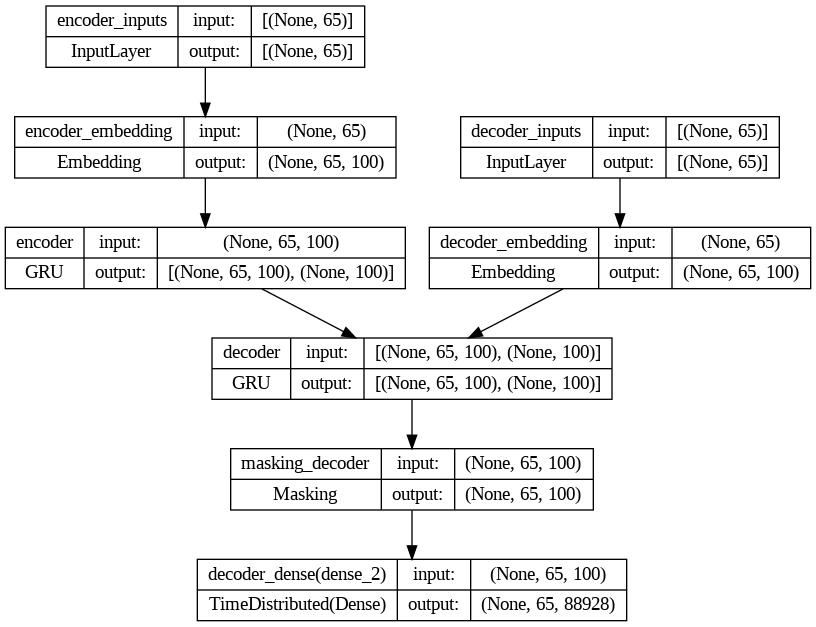

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

#### Training

In [ ]:
epoch_count = 20
batch_size = 100
patience = 2

early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [ ]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_data=([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data),batch_size=batch_size,epochs=epoch_count, callbacks=[early_stop])

Epoch 1/20
611/611 [==============================] - 952s 2s/step - loss: 2.3803 - val_loss: 1.7840
Epoch 2/20
611/611 [==============================] - 870s 1s/step - loss: 1.8303 - val_loss: 1.6030
Epoch 3/20
611/611 [==============================] - 874s 1s/step - loss: 1.6328 - val_loss: 1.4740
Epoch 4/20
611/611 [==============================] - 873s 1s/step - loss: 1.4626 - val_loss: 1.3946
Epoch 5/20
611/611 [==============================] - 885s 1s/step - loss: 1.3152 - val_loss: 1.3480
Epoch 6/20
611/611 [==============================] - 883s 1s/step - loss: 1.1847 - val_loss: 1.3180
Epoch 7/20
611/611 [==============================] - 867s 1s/step - loss: 1.0677 - val_loss: 1.3035
Epoch 8/20
611/611 [==============================] - 863s 1s/step - loss: 0.9626 - val_loss: 1.2948
Epoch 9/20
611/611 [==============================] - 865s 1s/step - loss: 0.8703 - val_loss: 1.2894
Epoch 10/20
611/611 [==============================] - 872s 1s/step - loss: 0.7915 - val_lo

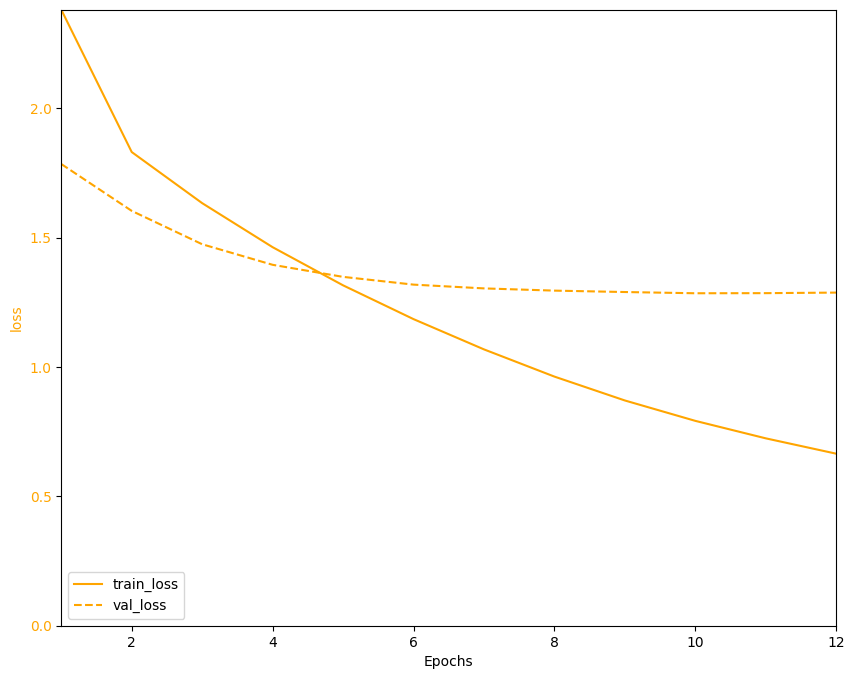

In [ ]:
plot_history(history)

#### Performance evaluation

We test the performance of the previously trained model.

In [ ]:
results = model.evaluate([test_encoder_input_data, test_decoder_input_data],test_decoder_output_data, batch_size = batch_size, verbose=0)
print('Loss: {:.3f}'.format(results))

Loss: 1.282


We save the pre-trained model.

In [ ]:
model.save(model_path)

#### Inference model

We define the same model used for training but for the inference phase.

**Inference encoder-decoder**

In [ ]:
# encoder
encoder_model = Model(inputs=encoder_inputs, outputs=(encoder_outputs, state_h))

# decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_hidden_state_input = Input(shape=(input_length, n_units))

dec_emb = dec_emb_layer(decoder_inputs)

(decoder_outputs, state_h_decoder) = decoder(dec_emb, initial_state=decoder_state_input_h)

masking_layer = Masking()
decoder_outputs = decoder_dense(masking_layer(decoder_outputs))

decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h], [decoder_outputs] + [state_h_decoder])

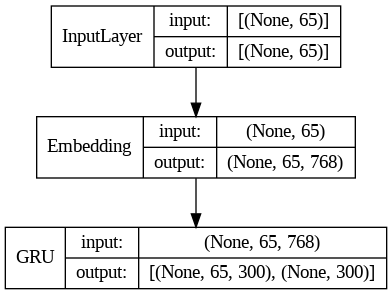

In [ ]:
keras.utils.plot_model(encoder_model, show_shapes = True, show_layer_names=False)

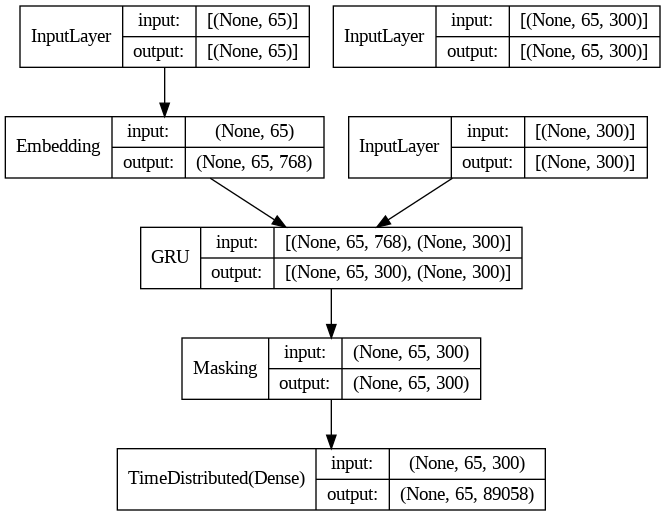

In [ ]:
keras.utils.plot_model(decoder_model, show_shapes = True, show_layer_names=False)

**Inference encoder-decoder from loaded model**

We reconstruct the encoder and decoder for the inference step, starting from the pre-trained model uploaded from Google Drive.

In [ ]:
# loaded_model = load_model(model_path)

In [ ]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 65, 768)      68391168    ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embedding (Embedding)  (None, 65, 768)      68391168    ['decoder_inputs[0][0]']         
                                                                                              

In [ ]:
# encoder
encoder_inputs = loaded_model.get_layer("encoder_inputs").input
encoder_outputs = loaded_model.get_layer("encoder").output[0]
state_h = loaded_model.get_layer("encoder").output[1]

encoder_model = Model(inputs=encoder_inputs, outputs=(encoder_outputs, state_h))

# decoder
dec_emb_layer = loaded_model.get_layer("decoder_embedding")
decoder_inputs = loaded_model.get_layer("decoder_inputs").input
decoder = loaded_model.get_layer("decoder")
decoder_dense = loaded_model.get_layer("decoder_dense")

decoder_state_input_h = Input(shape=(n_units,))
decoder_hidden_state_input = Input(shape=(input_length, n_units))

dec_emb = dec_emb_layer(decoder_inputs)

(decoder_outputs, state_h_decoder) = decoder(dec_emb, initial_state=decoder_state_input_h)

masking_layer = Masking()
decoder_outputs = decoder_dense(masking_layer(decoder_outputs))

decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h], [decoder_outputs] + [state_h_decoder])

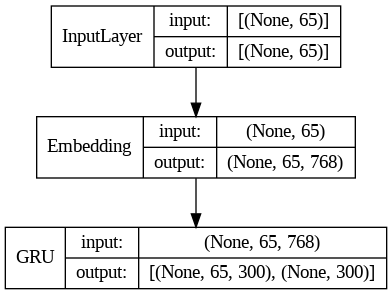

In [ ]:
keras.utils.plot_model(encoder_model, show_shapes = True, show_layer_names=False)

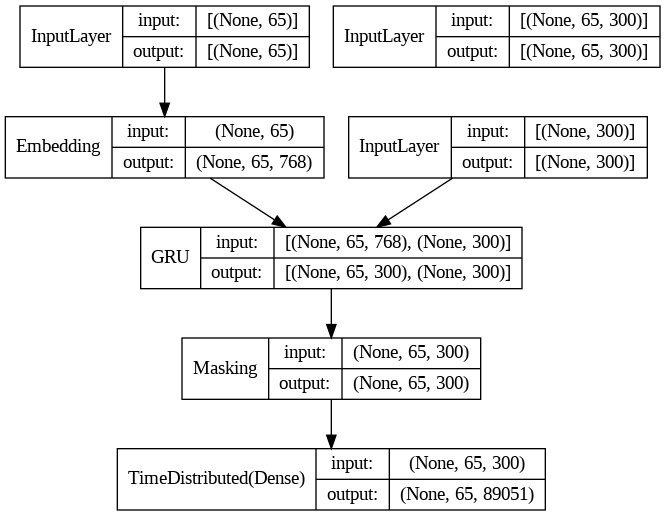

In [ ]:
keras.utils.plot_model(decoder_model, show_shapes = True, show_layer_names=False)

#### Visualize predictions

Now we want to visualize the model's predictions.

The `generate_prediction` method takes as input an *input_encoder* sequence of the testing split and reproduces the inference step by calling the components defined in the previous section.

In [ ]:
def generate_prediction(input_seq):

  # Encode the input as state vectors
  e_out, e_h = encoder_model.predict(input_seq.reshape(1, input_length))

  # Generate empty target sequence
  target_seq = np.zeros((1, 1))

  # Populate the first word of target sequence with the start word.
  target_seq[0, 0] = dictionary['\t'][0]

  stop_condition = False
  decoded_sentence = ''

  while not stop_condition:
    output_tokens, h = decoder_model.predict((target_seq, e_out, e_h))

    # Sample the token with maximum probability
    sampled_token_index = np.argmax(output_tokens[0, -1, :])

    sampled_token = tokenizer.sequences_to_texts([[sampled_token_index]])[0]

    if sampled_token != '\n':
      decoded_sentence += ' ' + sampled_token

    # Exit condition: either hit max length or find the stop word
    if sampled_token == '\n' or len(decoded_sentence.split()) > max_len:
      stop_condition = True

    # Update the target sequence
    target_seq = np.zeros((1, 1))
    target_seq[0,0] = sampled_token_index

    # Update internal states
    e_h = h

  return decoded_sentence

We choose to compute the predictions for the first `n_predictions` testing examples.

In [ ]:
%%capture

n_predictions = 100
predictions = {}

for i in range(n_predictions):
  input = test_set[i]["input"]
  output = test_set[i]["output"]
  input_seq = test_encoder_input_data[i]
  prediction = generate_prediction(input_seq)
  predictions[i] = (input, output, prediction)

In [ ]:
predictions = pd.DataFrame.from_dict(predictions, orient="index", columns=["input", "output", "prediction"])
predictions.head()

,input,output,prediction
0,"The story starts how they were rescued , introduced to Ginjou .","It starts how they were rescued , introduced to Ginjou .",", the energy was hard to process , and which energy . , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,"
1,like the Chlorophilic in kitty litter .,like the chlorophyll in kitty litter .,"in the 11 sensors . , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,"
2,Form two parts is two form of comfort to than on .,"Two sides , two different forms of comfort .",", are added to form my of than h . , , , , , , , , my of our , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,"
3,b ) Dwellins contracted for more than two months continuously by the same tenant ( long term holiday rentals ) .,b ) Dwellings contracted for more than two months continuously by the same tenant ( long-term holiday rentals ) .,"for very ? allowing , 000 for the same more different afcpe® and have been features by the same . , , , , , , , , , , , , , , , need . , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,"
4,Lovište is great for getaways of crowds .,Lovište is great for getaways from crowds .,"is great of enforcement for young : , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,"


#### Compute metrics

We calculate the values of the BLEU and GLEU metrics on the newly generated predictions.

In [ ]:
compute_metrics(predictions)

### LSTM

In this section, a network similar to the one defined in the previous section is implemented but, in this case, the Encoder and Decoder components will consist of an LSTM-type recurrent network.

#### Model

In [ ]:
model_path = project_path + "models/LSTM_1"

embedding_dim = 768
n_units = 300
input_length = max_len

In [ ]:
encoder_inputs = Input(shape=(input_length, ), name="encoder_inputs")
enc_emb_layer = Embedding(input_dim = len_dictionary, output_dim = embedding_dim, input_length = input_length, trainable = True, mask_zero=True, name="encoder_embedding")
enc_emb = enc_emb_layer(encoder_inputs)

encoder = LSTM(n_units, return_sequences=True, return_state=True, name="encoder", dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder(enc_emb)

decoder_inputs = Input(shape=(input_length, ), name="decoder_inputs")
dec_emb_layer = Embedding(input_dim = len_dictionary, output_dim = embedding_dim, input_length = input_length, trainable=True, mask_zero=True, name="decoder_embedding")
dec_emb = dec_emb_layer(decoder_inputs)

decoder = LSTM(n_units, return_sequences=True, return_state=True, name="decoder", dropout=0.4, recurrent_dropout=0.2)
(decoder_outputs, _ , _) = decoder(dec_emb, initial_state=[state_h, state_c])

decoder_dense = TimeDistributed(Dense(len_dictionary, activation="softmax"), name="decoder_dense")
masking_layer = Masking(name="masking_decoder")
decoder_outputs = decoder_dense(masking_layer(decoder_outputs))

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 65, 768)      68371200    ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embedding (Embedding)  (None, 65, 768)      68371200    ['decoder_inputs[0][0]']         
                                                                                              

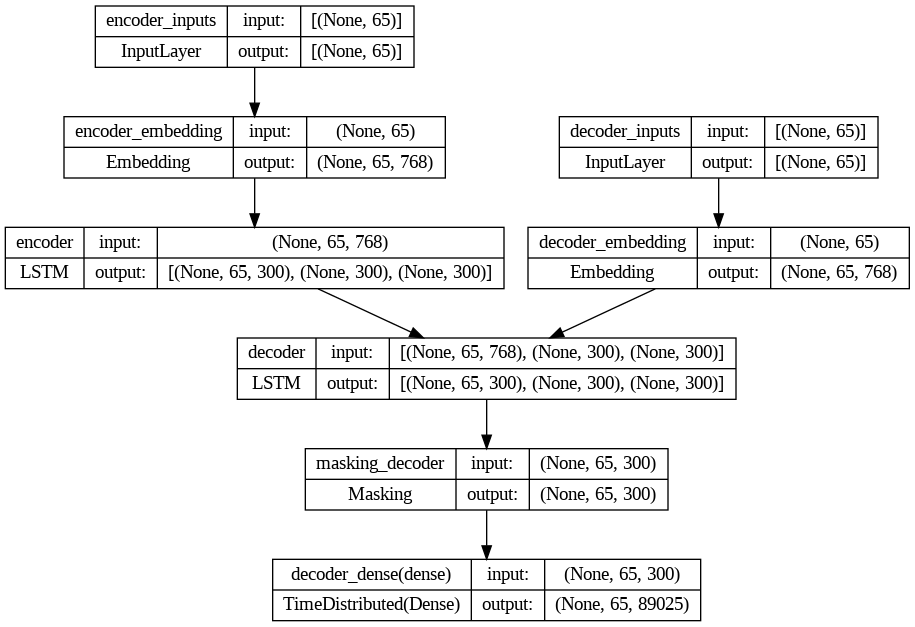

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

#### Model (with pre-trained Embedding)

We define an Encoder-Decoder model that exploits a pre-trained Embedding layer.


**Get pre-trained embedding data**

We download the data for the pre-trained embedding layer.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-06-02 09:32:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-06-02 09:32:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-02 09:32:37--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

he archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. We'll use the 300D ones.

In [ ]:
path_to_glove_file = os.path.join(
    "glove.6B.300d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [ ]:
num_tokens = len_dictionary
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[index] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 53047 words (36043 misses)


**Model definition**

In [ ]:
model_path = project_path + "models/LSTM_pre-trained"

n_units = 300
input_length = max_len

In [ ]:
encoder_inputs = Input(shape=(input_length, ), name="encoder_inputs")
enc_emb_layer = Embedding(input_dim = len_dictionary, output_dim = embedding_dim, input_length = input_length, embeddings_initializer=Constant(embedding_matrix), trainable = False, mask_zero=True, name="encoder_embedding")
enc_emb = enc_emb_layer(encoder_inputs)

encoder = LSTM(n_units, return_sequences=True, return_state=True, name="encoder", dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder(enc_emb)

decoder_inputs = Input(shape=(input_length, ), name="decoder_inputs")
dec_emb_layer = Embedding(input_dim = len_dictionary, output_dim = embedding_dim, input_length = input_length, embeddings_initializer=Constant(embedding_matrix), trainable=False, mask_zero=True, name="decoder_embedding")
dec_emb = dec_emb_layer(decoder_inputs)

decoder = LSTM(n_units, return_sequences=True, return_state=True, name="decoder", dropout=0.4, recurrent_dropout=0.4)
(decoder_outputs, _ , _) = decoder(dec_emb, initial_state=[state_h, state_c])

decoder_dense = TimeDistributed(Dense(len_dictionary, activation="softmax"), name="decoder_dense")
masking_layer = Masking(name="masking_decoder")
decoder_outputs = decoder_dense(masking_layer(decoder_outputs))

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 65, 300)      26727300    ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embedding (Embedding)  (None, 65, 300)      26727300    ['decoder_inputs[0][0]']         
                                                                                            

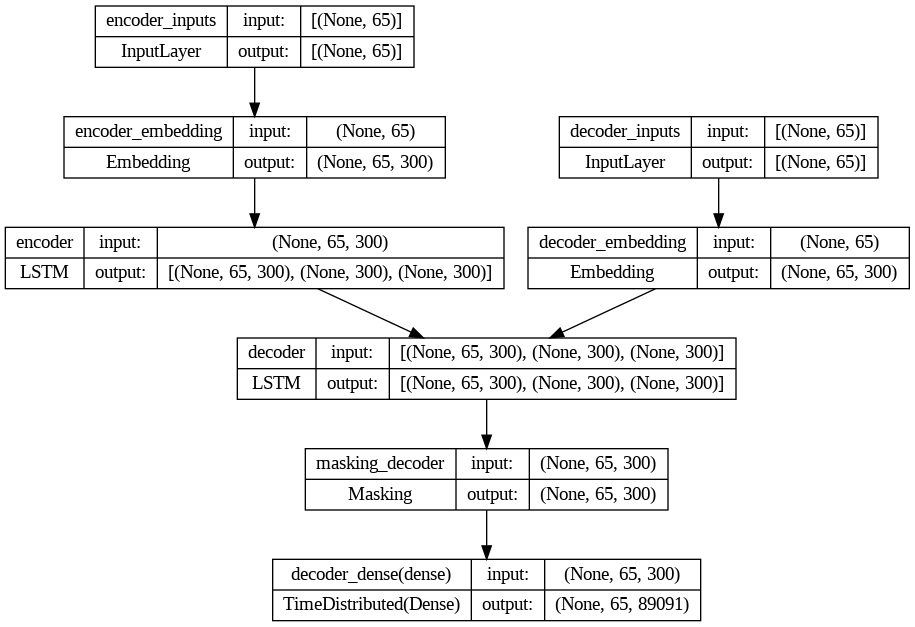

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

#### Training

In [ ]:
epoch_count = 25
batch_size = 100
patience = 3

early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [ ]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_data=([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data),batch_size=batch_size,epochs=epoch_count, callbacks=[early_stop])

# model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy')
# history = model.fit([encoder_input_data, decoder_input_data],decoder_output_data,validation_data=([cv_encoder_input_data,cv_decoder_input_data],cv_decoder_output_data),batch_size=batch_size,epochs=epoch_count, callbacks=[early_stop])

Epoch 1/25
611/611 [==============================] - 1004s 2s/step - loss: 2.3711 - val_loss: 1.8327
Epoch 2/25
611/611 [==============================] - 949s 2s/step - loss: 1.8911 - val_loss: 1.7308
Epoch 3/25
611/611 [==============================] - 959s 2s/step - loss: 1.7822 - val_loss: 1.6640
Epoch 4/25
611/611 [==============================] - 947s 2s/step - loss: 1.6718 - val_loss: 1.5770
Epoch 5/25
611/611 [==============================] - 950s 2s/step - loss: 1.5472 - val_loss: 1.4977
Epoch 6/25
611/611 [==============================] - 941s 2s/step - loss: 1.4247 - val_loss: 1.4375
Epoch 7/25
611/611 [==============================] - 958s 2s/step - loss: 1.3083 - val_loss: 1.3963
Epoch 8/25
611/611 [==============================] - 966s 2s/step - loss: 1.2004 - val_loss: 1.3667
Epoch 9/25
611/611 [==============================] - 951s 2s/step - loss: 1.1000 - val_loss: 1.3503
Epoch 10/25
611/611 [==============================] - 949s 2s/step - loss: 1.0068 - val_l

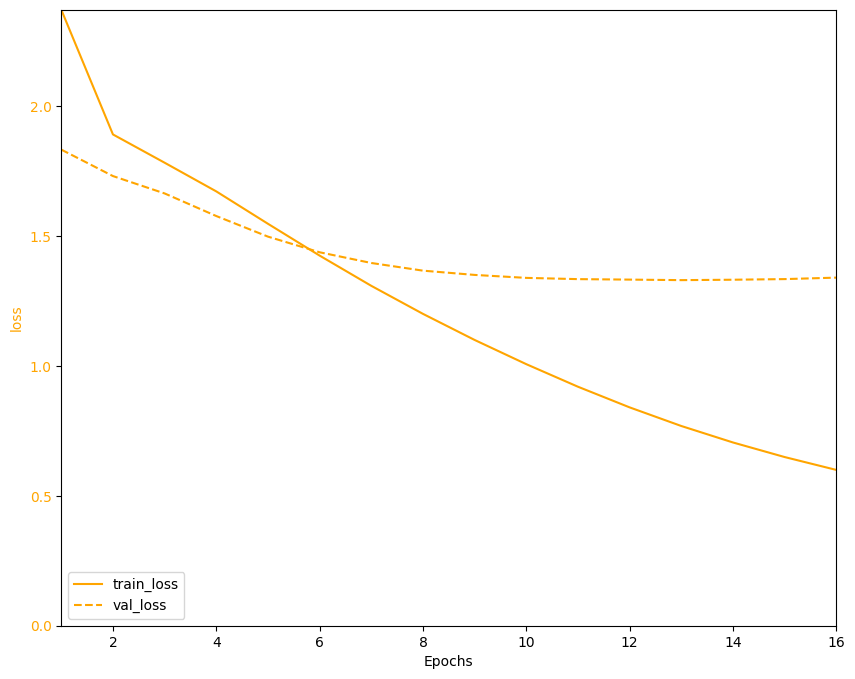

In [ ]:
plot_history(history)

#### Performance Evaluation

We test the performance of the previously trained model.

In [ ]:
results = model.evaluate([test_encoder_input_data, test_decoder_input_data],test_decoder_output_data, batch_size = batch_size, verbose=0)
print('Loss: {:.3f}'.format(results))

Loss: 1.321


We save the pre-trained model.

In [ ]:
model.save(model_path)

#### Inference model

We define the same model used for training but for the inference phase.

**Inference encoder-decoder**

In [ ]:
# encoder
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,state_h, state_c])

# decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units, ))
decoder_hidden_state_input = Input(shape=(input_length, n_units))

dec_emb = dec_emb_layer(decoder_inputs)

(decoder_outputs, state_h_decoder, state_c_decoder) = decoder(dec_emb, initial_state=[decoder_state_input_h, decoder_state_input_c])

masking_layer = Masking()
decoder_outputs = decoder_dense(masking_layer(decoder_outputs))

decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], [decoder_outputs] + [state_h_decoder, state_c_decoder])

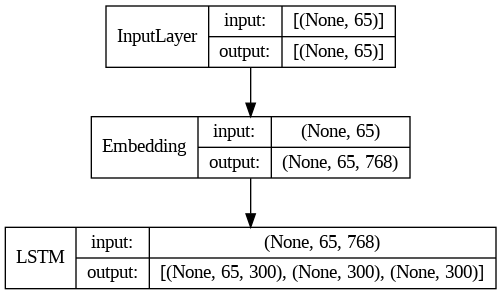

In [ ]:
keras.utils.plot_model(encoder_model, show_shapes = True, show_layer_names=False)

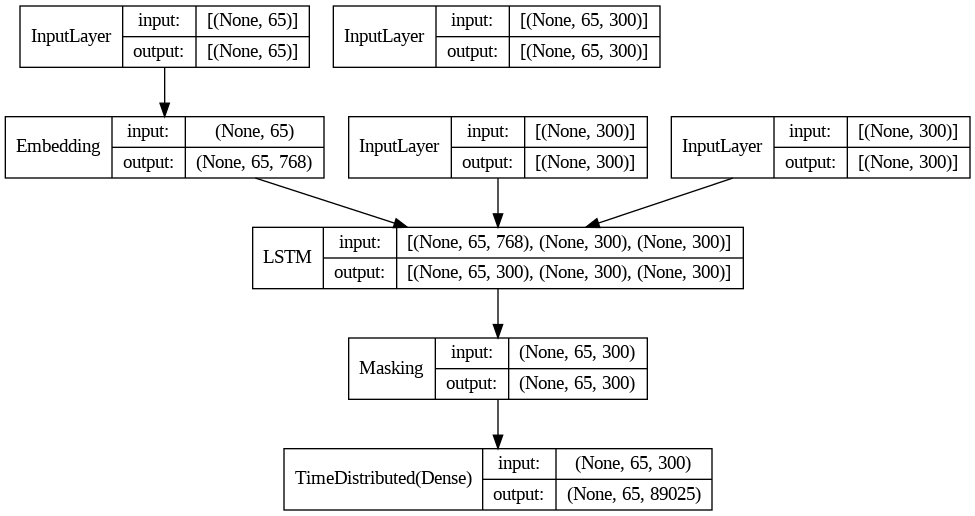

In [ ]:
keras.utils.plot_model(decoder_model, show_shapes = True, show_layer_names=False)

**Inference encoder-decoder from loaded model**

We reconstruct the encoder and decoder for the inference step, starting from the pre-trained model uploaded from Google Drive.

In [ ]:
# loaded_model = load_model(model_path)

In [ ]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 65)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 65, 768)      68371200    ['encoder_inputs[0][0]']         
                                                                                                  
 decoder_embedding (Embedding)  (None, 65, 768)      68371200    ['decoder_inputs[0][0]']         
                                                                                              

In [ ]:
# encoder
encoder_inputs = loaded_model.get_layer("encoder_inputs").input
encoder_outputs = loaded_model.get_layer("encoder").output[0]
state_h = loaded_model.get_layer("encoder").output[1]
state_c = loaded_model.get_layer("encoder").output[2]

encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# decoder
dec_emb_layer = loaded_model.get_layer("decoder_embedding")
decoder_inputs = loaded_model.get_layer("decoder_inputs").input
decoder = loaded_model.get_layer("decoder")
decoder_dense = loaded_model.get_layer("decoder_dense")

decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_hidden_state_input = Input(shape=(input_length, n_units))

dec_emb = dec_emb_layer(decoder_inputs)

(decoder_outputs, state_h_decoder, state_c_decoder) = decoder(dec_emb, initial_state=[decoder_state_input_h, decoder_state_input_c])

masking_layer = Masking()
decoder_outputs = decoder_dense(masking_layer(decoder_outputs))

decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], [decoder_outputs] + [state_h_decoder, state_c_decoder])

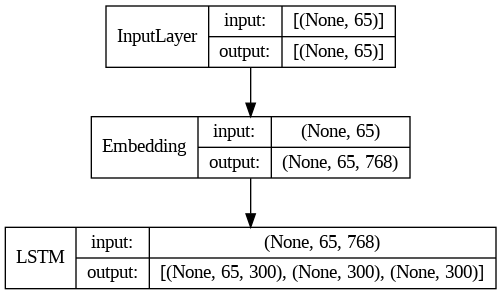

In [ ]:
keras.utils.plot_model(encoder_model, show_shapes = True, show_layer_names=False)

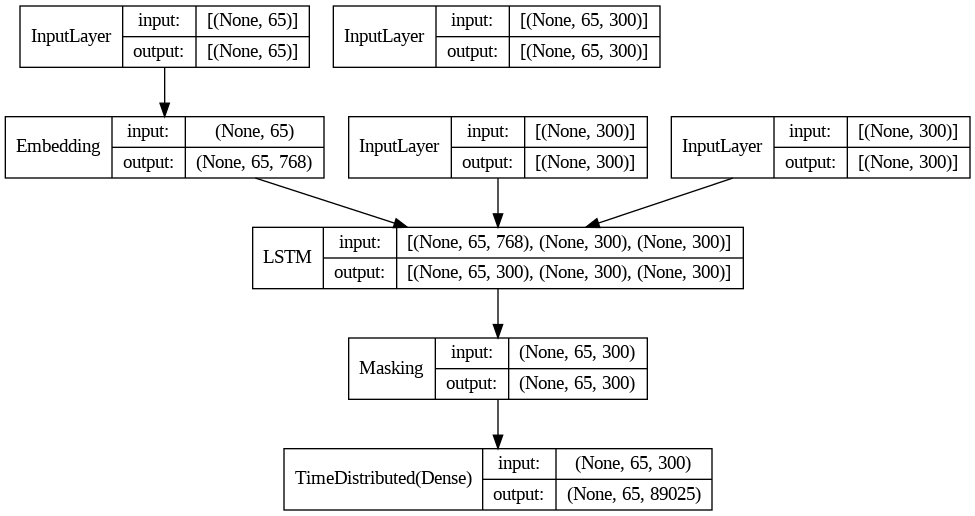

In [ ]:
keras.utils.plot_model(decoder_model, show_shapes = True, show_layer_names=False)

#### Visualize predictions

Now we want to visualize the model's predictions.

The `generate_prediction` method takes as input an *input_encoder* sequence of the testing split and reproduces the inference step by calling the components defined in the previous section.

In [ ]:
def generate_prediction(input_seq):

  # Encode the input as state vectors
  (e_out, e_h, e_c) = encoder_model.predict(input_seq.reshape(1, input_length))

  # Generate empty target sequence
  target_seq = np.zeros((1, 1))

  # Populate the first word of target sequence with the start word.
  target_seq[0, 0] = dictionary['\t'][0]

  stop_condition = False
  decoded_sentence = ''

  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

    # Sample the token with maximum probability
    sampled_token_index = np.argmax(output_tokens[0, -1, :])

    sampled_token = tokenizer.sequences_to_texts([[sampled_token_index]])[0]

    if sampled_token != '\n':
      decoded_sentence += ' ' + sampled_token

    # Exit condition: either hit max length or find the stop word
    if sampled_token == '\n' or len(decoded_sentence.split()) > max_len:
      stop_condition = True

    # Update the target sequence
    target_seq = np.zeros((1, 1))
    target_seq[0,0] = sampled_token_index

    # Update internal states
    (e_h, e_c) = (h, c)

  return decoded_sentence

We choose to compute the predictions for the first `n_predictions` testing examples.

In [ ]:
%%capture

n_predictions = 100
predictions = {}

for i in range(n_predictions):
  input = test_set[i]["input"]
  output = test_set[i]["output"]
  input_seq = test_encoder_input_data[i]
  prediction = generate_prediction(input_seq)
  predictions[i] = (input, output, prediction)

In [ ]:
predictions = pd.DataFrame.from_dict(predictions, orient="index", columns=["input", "output", "prediction"])
predictions.head()

,input,output,prediction
0,honeywell dr4300 chart recorder from cole parmer .,honeywell dr4300 chart recorder from cole parmer .,basic chart from the zombie controller . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco
1,see if you can get through this without laughing,See if you can get through this without laughing .,see if you can get this without me . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco
2,"It’s an industrial single unit studied to provide all the functions of a bathroom , including all the technical one , essentials during the building construction process .","It’s an industrial single unit studied to provide all the functions of a bathroom , including all the technical ones , essentials during the building construction process .","it’s a commercial manufacturer of an industrial network with the two dimensional elements , two different areas , which will be used to the top of the system . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco"
3,Best Easter Coloring Page Bible Pinterest For my for Cross 17 .,Best Easter Coloring Pages Bible Pinterest For Cross 17 .,best anthias for my house street catalog for post on pinterest . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco .
4,"For the first time in here over a decade , the Frist Center for the Visual Arts is putting together major exhibition of Islamic art .","For the first time in more than a decade , the Frist Center for the Visual Arts is putting together a major exhibition of Islamic art .","for the first time , here is a new testament to the director of the american family— love for the american network in stockholm , with a real estate . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco . francisco ."


#### Compute metrics

We calculate the values of the BLEU and GLEU metrics on the newly generated predictions.

In [ ]:
compute_metrics(predictions)

# Transformers

> - Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. The main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.


## No pre-trained Transformer

Inspired by [*Neural machine translation with a Transformer and Keras*](https://www.tensorflow.org/text/tutorials/transformer) notebook.

### Setup

- `dataset_size`: number of examples to be included in the dataset
- `MEAN_LEN`: average number of words in the first *dataset_size* examples, calculated in the previous section
- `MAX_TOKENS`: maximum number of words in the filtered dataset, calculated in the previous section
- `BATCH_SIZE`: batch size
- `BUFFER_SIZE`: buffer size for the shuffle operation

In [ ]:
model_path = project_path + 'models/TransformerNoPreTrained_1'

dataset_size = 100000
MEAN_LEN = 33
MAX_TOKENS = 65
BATCH_SIZE = 64
BUFFER_SIZE = 20000

### Data handling

#### Download and filter the dataset

We load the dataset from the *HuggingFace* library, taking advantage of the `load_dataset` module.

We enable `streaming` mode since the size of the dataset exceeds the disk space of the machine remotely: the data actually loaded into memory will be the data we decide to call with the `take` method.

In [ ]:
%%capture

dataset = load_dataset("liweili/c4_200m", split="train", streaming=True)

dataset_streamed = dataset.take(dataset_size)
dataset = Dataset.from_list(list(dataset_streamed))

print('Dataset size: ', dataset.num_rows)

In [ ]:
dataset

Dataset({
    features: ['input', 'output'],
    num_rows: 100000
})

We separate words from punctuation to later filter the dataset by the number of words in the input sequence.

In [ ]:
dataset = dataset.map(separate_punctuation)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.filter(lambda example: len(example["input"].split()) <= MEAN_LEN)
print("Dopo il filtering il dataset ha " + str(dataset.num_rows) + " elementi.")

Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dopo il filtering il dataset ha 76347 elementi.


#### Set up the tokenizer

The tokenization step is necessary because deep learning models are unable to process sequences of text, which will need to be transformed into sequences of integers (tokens).

The tutorial taken as an example uses a **subword-level** tokenizer:

> *That tutorial optimizes two `text.BertTokenizer` objects (one for English, one for Portuguese) for [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en) and exports them in a TensorFlow `saved_model` format.*

In our case we will take advantage of the English language tokenizer only.

In [ ]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

tokenizers = tf.saved_model.load(model_name)

184801/184801 [==============================] - 0s 1us/step


Both tokenizers have the same methods:

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing.

In [ ]:
print('> This is a batch of strings:')
for elem in dataset[:3]["input"]:
  print(elem)

> This is a batch of strings:
Bitcoin is for  $ 7 , 094 this morning ,  which CoinDesk says . 
The effect of widespread dud targets two face up attack position monsters on the field . 
Much many brands and sellers still in the market . 


In [ ]:
encoded = tokenizers.en.tokenize(dataset[:3]["input"])

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 2506, 80, 85, 6, 24, 13, 17, 1374, 1044, 81, 1117, 13, 148, 3455, 530, 2240, 484, 511, 15, 3]
[2, 71, 987, 74, 4534, 40, 2299, 3538, 165, 455, 130, 1209, 1319, 6237, 5529, 88, 92, 71, 692, 15, 3]
[2, 170, 180, 5227, 72, 1793, 343, 235, 77, 71, 961, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human-readable text:

In [ ]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
bitcoin is for $ 7 , 094 this morning , which coindesk says .
the effect of widespread dud targets two face up attack position monsters on the field .
much many brands and sellers still in the market .


The lower level `lookup` method converts from token-IDs to token text:

In [ ]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'bitcoin', b'is', b'for', b'$', b'7', b',', b'0', b'##9',
  b'##4', b'this', b'morning', b',', b'which', b'co', b'##in', b'##des',
  b'##k', b'says', b'.', b'[END]']                                      ,
 [b'[START]', b'the', b'effect', b'of', b'widespread', b'd', b'##ud',
  b'targets', b'two', b'face', b'up', b'attack', b'position', b'mo',
  b'##nster', b'##s', b'on', b'the', b'field', b'.', b'[END]']       ,
 [b'[START]', b'much', b'many', b'brands', b'and', b'sell', b'##ers',
  b'still', b'in', b'the', b'market', b'.', b'[END]']                ]>

The distribution of tokens per example in the dataset is as follows:

In [ ]:
lengths = []

def calculate_lengths(examples):

  input_tokens = tokenizers.en.tokenize(examples["input"])
  output_tokens = tokenizers.en.tokenize(examples["output"])

  for input in input_tokens:
    lengths.append(input_tokens.row_lengths())
    lengths.append(output_tokens.row_lengths())

dataset.map(calculate_lengths, batched=True)

Map:   0%|          | 0/76347 [00:00<?, ? examples/s]

Dataset({
    features: ['input', 'output'],
    num_rows: 76347
})

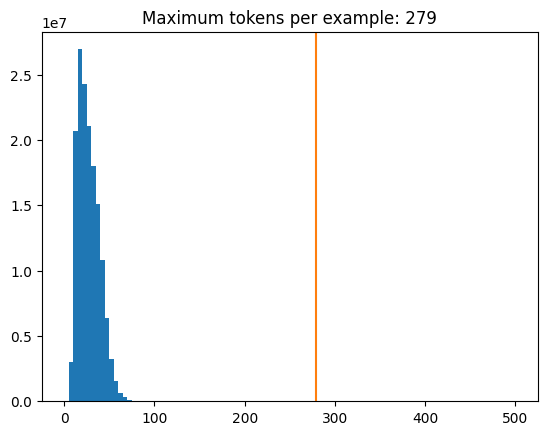

In [ ]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

In [ ]:
mean_tokens = int(np.mean(all_lengths))
print(f'Mean tokens per example: {mean_tokens}')

Mean tokens per example: 26


#### Split the dataset

We perform dataset splitting into training, validation and testing splits.

In [ ]:
dataset_splitted = dataset.train_test_split(test_size=0.2)
train_set = dataset_splitted["train"]

dataset_splitted = dataset_splitted["test"].train_test_split(test_size=0.5)
eval_set = dataset_splitted["train"]
test_set = dataset_splitted["test"]

print('Training set size: ', train_set.num_rows)
print('Validation set size: ', eval_set.num_rows)
print('Test set size: ', test_set.num_rows)

Training set size:  61077
Validation set size:  7635
Test set size:  7635


#### Pre-processing

The `pre_processing_batch` function takes as input a batch of examples from the dataset and computes the corresponding token sequences, then applying padding so that each of these has maximum length equal to `MAX_TOKENS`. This is done for both input and target sequences.

Consequently, 3 new columns are created in the splits of the dataset:
- `inputs`
- `target_inputs`, from which the sequence end token has been removed
- `target_labels`, from which the sequence start token has been removed

In [ ]:
def pre_processing_batch(examples):
    inputs = tokenizers.en.tokenize(examples["input"]).to_list() # Tokenize inputs
    inputs = pad_sequences(inputs, maxlen=MAX_TOKENS, padding="post") # Add padding to inputs

    targets = tokenizers.en.tokenize(examples["output"]) # Tokenize outputs
    target_input = pad_sequences(targets[:, :-1].to_list(), maxlen=MAX_TOKENS+1, padding="post") # Drop the [END] tokens and pad
    target_label = pad_sequences(targets[:, 1:].to_list(), maxlen=MAX_TOKENS+1, padding="post") # Drop the [START] tokens and pad

    # Create new columns on the dataset
    examples["inputs"] = inputs
    examples["target_inputs"] = target_input
    examples["target_labels"] = target_label

    return examples

train_set = train_set.map(pre_processing_batch, batched=True)
eval_set = eval_set.map(pre_processing_batch, batched=True)
test_set = test_set.map(pre_processing_batch, batched=True)

Map:   0%|          | 0/61077 [00:00<?, ? examples/s]

Map:   0%|          | 0/7635 [00:00<?, ? examples/s]

Map:   0%|          | 0/7635 [00:00<?, ? examples/s]

 </section>

We visualize the new structure of the training split and the first records in it.

In [ ]:
train_set

Dataset({
    features: ['input', 'output', 'inputs', 'target_inputs', 'target_labels'],
    num_rows: 61077
})

In [ ]:
pd.DataFrame.from_dict(train_set).head()

,input,output,inputs,target_inputs,target_labels
0,Morning fog veils dramatic waterfall in the Sumter National Forest of upstate South Carolina .,Morning fog veils this dramatic waterfall in the Sumter National Forest of upstate South Carolina .,"[2, 1117, 6714, 142, 3734, 3329, 318, 6434, 77, 71, 2356, 756, 850, 1138, 74, 6365, 4327, 905, 6085, 3293, 15, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 1117, 6714, 142, 3734, 81, 3329, 318, 6434, 77, 71, 2356, 756, 850, 1138, 74, 6365, 4327, 905, 6085, 3293, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1117, 6714, 142, 3734, 81, 3329, 318, 6434, 77, 71, 2356, 756, 850, 1138, 74, 6365, 4327, 905, 6085, 3293, 15, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Therefore hear ListView we reference therefore and set an adapter .,We therefore reference that ListView and set its adapter .,"[2, 1494, 586, 1261, 5577, 78, 3856, 1494, 72, 450, 111, 3940, 227, 15, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 78, 1494, 3856, 75, 1261, 5577, 72, 450, 247, 3940, 227, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[78, 1494, 3856, 75, 1261, 5577, 72, 450, 247, 3940, 227, 15, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Supporting heart health Chia seeds can help reduce blood preessure containing essential futty acids Omega 3 and 6 .,Supports Heart Health Chia seeds can help reduce blood pressure as contains essential fatty acids Omega 3 and 6 .,"[2, 6335, 649, 369, 39, 4845, 303, 3153, 94, 300, 2607, 665, 2942, 2560, 869, 3777, 138, 1779, 42, 1804, 968, 6036, 51, 1572, 5140, 20, 72, 23, 15, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 5442, 649, 369, 39, 4845, 303, 3153, 94, 300, 2607, 665, 1450, 100, 3778, 1779, 1820, 968, 6036, 51, 1572, 5140, 20, 72, 23, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5442, 649, 369, 39, 4845, 303, 3153, 94, 300, 2607, 665, 1450, 100, 3778, 1779, 1820, 968, 6036, 51, 1572, 5140, 20, 72, 23, 15, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,J Am Acad Psychiatry Law 2013 ; 41 ( 3 ) : 337-43 ) No ( abstract is available .,J Am Acad Psychiatry Law . 2013 ; 41 ( 3 ) : 337-43 . No abstract available .,"[2, 46, 340, 37, 2875, 178, 52, 6005, 1173, 858, 3301, 759, 447, 6380, 28, 21, 1205, 10, 20, 11, 27, 20, 1223, 1122, 14, 21, 1223, 11, 154, 10, 3584, 80, 888, 15, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 46, 340, 37, 2875, 178, 52, 6005, 1173, 858, 3301, 759, 15, 447, 6380, 28, 21, 1205, 10, 20, 11, 27, 20, 1223, 1122, 14, 21, 1223, 15, 154, 3584, 888, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[46, 340, 37, 2875, 178, 52, 6005, 1173, 858, 3301, 759, 15, 447, 6380, 28, 21, 1205, 10, 20, 11, 27, 20, 1223, 1122, 14, 21, 1223, 15, 154, 3584, 888, 15, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"Tension bindings of ABC to household connection , when the distance between the posts is greater than standard .","Tension binding of ABC to household connection , when the distance between the posts is greater than standard .","[2, 3702, 2996, 2493, 74, 37, 59

#### Create tf dataset

With the `istantiate_tf_dataset` function, we create a Tensorflow dataset from a HuggingFace dataset so that we can take advantage of some optimizations in training, validation, and testing, such as splitting into batches.

We eliminate the input and output columns containing string sequences; in the next steps we will only need the sequences of token ids.

The `fit` function expects pairs (inputs, labels) where the inputs are additional pairs of token sequences for the input and the reference target of each example.

In [ ]:
@tf.function
@tf.autograph.experimental.do_not_convert
def istantiate_tf_dataset(ds):
  ds = ds.remove_columns(["input", "output"])
  inputs = tf.convert_to_tensor(ds["inputs"], dtype=tf.int64)
  target_inputs = tf.convert_to_tensor(ds["target_inputs"], dtype=tf.int64)
  target_labels = tf.convert_to_tensor(ds["target_labels"], dtype=tf.int64)
  return tf.data.Dataset.from_tensor_slices(((inputs, target_inputs), target_labels))

tf_train_set = istantiate_tf_dataset(train_set)
tf_eval_set = istantiate_tf_dataset(eval_set)
tf_test_set = istantiate_tf_dataset(test_set)

In [ ]:
tf_train_set

<_VariantDataset element_spec=((TensorSpec(shape=(65,), dtype=tf.int64, name=None), TensorSpec(shape=(66,), dtype=tf.int64, name=None)), TensorSpec(shape=(66,), dtype=tf.int64, name=None))>

The `make_batches` function performs data shuffling (if enabled line of code) and splitting the dataset taken as input into batches.

In addition, the `prefetch` method allows the dataset to be run in parallel with the model, so that data is available when needed.

In [ ]:
def make_batches(ds):
  return (
      ds
      #.shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

train_batches = make_batches(tf_train_set)
val_batches = make_batches(tf_eval_set)
test_batches = make_batches(tf_test_set)

In [ ]:
train_batches

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 65), dtype=tf.int64, name=None), TensorSpec(shape=(None, 66), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 66), dtype=tf.int64, name=None))>

**Test the Dataset**

In [ ]:
for (input, output), output_labels in train_batches.take(1):
  break

print(input.shape)
print(output.shape)
print(output_labels.shape)

(64, 65)
(64, 66)
(64, 66)


`output` and `output_labels` are the same sequences of tokens but shifted by 1:

In [ ]:
print(output[0][:10])
print(output_labels[0][:10])

tf.Tensor([   2 1117 6714  142 3734   81 3329  318 6434   77], shape=(10,), dtype=int64)
tf.Tensor([1117 6714  142 3734   81 3329  318 6434   77   71], shape=(10,), dtype=int64)


### Define the components

> Transformer It follows the same general pattern as a standard sequence-to-sequence model with an encoder and a decoder.

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>


**The embedding and positional encoding layer**

> The inputs to both the encoder and decoder use the same embedding and positional encoding logic.

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

> Given a sequence of tokens, both the input tokens and target tokens have to be converted to vectors using a `tf.keras.layers.Embedding` layer.

> The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a [bag of words](https://developers.google.com/machine-learning/glossary#bag-of-words) instance, `how are you`, `how you are`, `you how are`, and so on, are indistinguishable.

> A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

> The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

> So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


We visualize the result by applying the `PositionalEmbedding` layer.

In [ ]:
embed = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

input_emb = embed(input)
output_emb = embed(output)

In [ ]:
output_emb._keras_mask

<tf.Tensor: shape=(64, 66), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

**Add and normalize**

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

> These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a `LayerNormalization` layer.

> The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each.

> The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are **updated** by the attention layers instead of **replaced**), while the normalization maintains a reasonable scale for the outputs.

> Note: The implementations, below, use the `Add` layer to ensure that Keras masks are propagated (the `+` operator does not).



**The base attention layer**

> Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`.

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

> To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass.

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

**The cross attention layer**

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder.

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

> To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer:

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

> The caricature below shows how information flows through this layer. The columns represent the weighted sum over the context sequence.

For simplicity the residual connections are not shown.

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

> The output length is the length of the `query` sequence, and not the length of the context `key/value` sequence.

In [ ]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(input_emb.shape)
print(output_emb.shape)
print(sample_ca(output_emb, input_emb).shape)

(64, 65, 512)
(64, 66, 512)
(64, 66, 512)


**The global self attention layer**

> This layer is responsible for processing the context sequence, and propagating information along its length:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

> Since the context sequence is fixed while the text is being generated, information is allowed to flow in both directions.

> The global self attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel.

> To implement this layer you just need to pass the target sequence, `x`, as both the `query`, and `value` arguments to the `mha` layer:

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(input_emb.shape)
print(sample_gsa(input_emb).shape)

(64, 65, 512)
(64, 65, 512)


<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

**The causal self attention layer**

> This layer does a similar job as the global self attention layer, for the output sequence:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

> This needs to be handled differently from the encoder's global self attention layer.

> Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this _efficient_, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".

> A causal model is efficient in two ways:

> 1. In training, it lets you compute loss for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.


> To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.
This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

> The causal mask ensures that each location only has access to the locations that come before it:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

<table>
</tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(output_emb.shape)
print(sample_csa(output_emb).shape)

(64, 66, 512)
(64, 66, 512)


**The feed forward network**

> The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

> The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


> The output is the same shape as the input:

In [ ]:
sample_ffn = FeedForward(512, 2048)

print(output_emb.shape)
print(sample_ffn(output_emb).shape)

(64, 66, 512)
(64, 66, 512)


**The encoder layer**

> The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

> The output will have the same shape as the input:

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(input_emb.shape)
print(sample_encoder_layer(input_emb).shape)

(64, 65, 512)
(64, 65, 512)


**The encoder**

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

> The encoder consists of:

> - A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

> Test the encoder:

In [ ]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(input, training=False)

# Print the shape.
print(input.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 65)
(64, 65, 512)


**The decoder layer**

> The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

> Test the decoder layer:

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=output_emb, context=input_emb)

print(output_emb.shape)
print(input_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 66, 512)
(64, 65, 512)
(64, 66, 512)


**The decoder**

> Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s:

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

> Test the decoder:

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output_decoder = sample_decoder(
    x=output,
    context=input_emb)

# Print the shapes.
print(output.shape)
print(input_emb.shape)
print(output_decoder.shape)

(64, 66)
(64, 65, 512)
(64, 66, 512)


In [ ]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 66, 65])

### The Transformer

> You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer which converts the resulting vector at each location into output token probabilities.

> The output of the decoder is the input to this final linear layer.

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

**Hyperparameters**

> To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

> The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

> The number of self-attention heads remains the same (`num_heads=8`).


In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

**Try it out**

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [ ]:
output_transformer = transformer((input, output))

print(output.shape)
print(input.shape)
print(output_transformer.shape)

(64, 66)
(64, 65)
(64, 66, 7010)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 66, 65)


In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3536128   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_38 (Dense)            multiple                  904290    
                                                                 
Total params: 10,087,522
Trainable params: 10,087,522
Non-trainable params: 0
_________________________________________________________________


### Training

#### Setup

**Set up the optimizer**

> Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

**Set up the loss and metrics**

> Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

#### Run

**Train the model**

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

patience = 2
early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

In [ ]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches,
                callbacks=[early_stop])

Epoch 1/20
955/955 [==============================] - 281s 252ms/step - loss: 6.8380 - masked_accuracy: 0.1164 - val_loss: 5.3287 - val_masked_accuracy: 0.2445
Epoch 2/20
955/955 [==============================] - 185s 194ms/step - loss: 4.3618 - masked_accuracy: 0.3681 - val_loss: 3.1710 - val_masked_accuracy: 0.5385
Epoch 3/20
955/955 [==============================] - 185s 194ms/step - loss: 2.5334 - masked_accuracy: 0.6273 - val_loss: 1.7295 - val_masked_accuracy: 0.7698
Epoch 4/20
955/955 [==============================] - 185s 194ms/step - loss: 1.6813 - masked_accuracy: 0.7594 - val_loss: 1.4878 - val_masked_accuracy: 0.7997
Epoch 5/20
955/955 [==============================] - 184s 193ms/step - loss: 1.4634 - masked_accuracy: 0.7855 - val_loss: 1.3762 - val_masked_accuracy: 0.8090
Epoch 6/20
955/955 [==============================] - 188s 196ms/step - loss: 1.2969 - masked_accuracy: 0.8032 - val_loss: 1.2985 - val_masked_accuracy: 0.8169
Epoch 7/20
955/955 [====================

### Performance evalutation

In [ ]:
results = transformer.evaluate(test_batches)
print('Loss: {:.3f} Accuracy: {:.3f}'.format(results[0],results[1]))

120/120 [==============================] - 10s 82ms/step - loss: 1.1722 - masked_accuracy: 0.8298
Loss: 1.172 Accuracy: 0.830


### Inference model

> You can now test the model. The following steps are used for inference:

> * Encode the input sentence using the tokenizer. This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

> Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

> Define the `InferenceModel` class by subclassing `tf.Module`:

In [ ]:
class InferenceModel(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.en.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
model = InferenceModel(tokenizers, transformer)

Testiamo

In [ ]:
def print_prediction(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [ ]:
sentence = test_set[0]["input"]
ground_truth = test_set[0]["output"]

text, tokens, attention_weights = model(
    tf.constant(sentence))
print_prediction(sentence, text, ground_truth)

Input:         : 112cm wide very strong quality dress/craft cotton poplin fabric with all over geometric triangle print in green ,  orange ,  yellow  .  . ｔ򞿧ｔand blues . 
Prediction     : 112cm wide very strong quality dress / craft cotton poplin fabric with all over geometric triangle print in green , orange , yellow . [UNK] blues .
Ground truth   : 112cm wide very good quality dress/craft cotton poplin fabric with an all over geometric triangle print in green ,  orange ,  yellow and blues . 


Example 2:

In [ ]:
sentence = test_set[1]["input"]
ground_truth = test_set[1]["output"]

text, tokens, attention_weights = model(
    tf.constant(sentence))
print_prediction(sentence, text, ground_truth)

Input:         : my subjekt is councelling but it is no an option . 
Prediction     : my subjekt is counseling but it is no option .
Ground truth   : my subject is counseling but that is not an option . 


Example 3:

In [ ]:
sentence = test_set[2]["input"]
ground_truth = test_set[2]["output"]

text, tokens, attention_weights = model(
    tf.constant(sentence))
print_prediction(sentence, text, ground_truth)

Input:         : Shaub said at the time that Trump will beginning an environment where ethics don ' t something matter
Prediction     : shaub said at the time that trump will begin an environment where ethics don ' t something matter .
Ground truth   : Shaub said at the time that Trump has created an environment where ethics don ' t matter . 


### Visualize predictions

Generiamo e visualizziamo `n_predictions` predizioni.

In [ ]:
n_predictions = 100
predictions = {}

for i in tqdm(range(n_predictions)):
  sentence = test_set[i]["input"]
  ground_truth = test_set[i]["output"]
  prediction, prediction_tokens, attention_weights = model(tf.constant(sentence))
  predictions[i] = (sentence, ground_truth, prediction.numpy().decode("utf-8"))

100%|██████████| 100/100 [09:58<00:00,  5.98s/it]


In [ ]:
predictions = pd.DataFrame.from_dict(predictions, orient="index", columns=["input", "output", "prediction"])
predictions.head()

,input,output,prediction
0,"112cm wide very strong quality dress/craft cotton poplin fabric with all over geometric triangle print in green , orange , yellow . . ｔ򞿧ｔand blues .","112cm wide very good quality dress/craft cotton poplin fabric with an all over geometric triangle print in green , orange , yellow and blues .","112cm wide very strong quality dress / craft cotton poplin fabric with all over geometric triangle print in green , orange , yellow . [UNK] blues ."
1,my subjekt is councelling but it is no an option .,my subject is counseling but that is not an option .,my subjekt is counseling but it is no option .
2,Shaub said at the time that Trump will beginning an environment where ethics don ' t something matter,Shaub said at the time that Trump has created an environment where ethics don ' t matter .,shaub said at the time that trump will begin an environment where ethics don ' t something matter .
3,adapt to jaw crusher replacement parts spare C125 swing jaw plate . . Ore Mining High Manganese Casting by Steel Jaw Crusher Spare Parts .,adapt to jaw crusher replacement parts spare C125 swing jaw plate . . Ore Mining High Manganese Steel Casting Jaw Crusher Spare Parts .,adapt to jaw crusher replacement parts spare c125 swing jaw plate . . . ore mining high manganese casting by steel jaw crusher spare parts .
4,An Pbulic War Zone – The violent crisis in the Espirito Santo state .,An Urban War Zone – The violent crisis in the Espirito Santo state .,an pbulic war zone – the violent crisis in the espirito santo state .


### Compute metrics

In [ ]:
compute_metrics(predictions)

### Save and test loaded model

> You can export it as a `tf.saved_model`.

> Create a class called `ExportModel` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.model(sentence, max_length=MAX_TOKENS)

    return result

In [ ]:
model = ExportModel(model)

In [ ]:
model(test_set[0]["input"]).numpy().decode("utf-8")

'112cm wide very strong quality dress / craft cotton poplin fabric with all over geometric triangle print in green , orange , yellow . [UNK] blues .'

In [ ]:
tf.saved_model.save(model, export_dir=model_path)

In [ ]:
reloaded = tf.saved_model.load(model_path)

In [ ]:
reloaded(test_set[0]["input"]).numpy().decode("utf-8")

'112cm wide very strong quality dress / craft cotton poplin fabric with all over geometric triangle print in green , orange , yellow . [UNK] blues .'

## Fine-tuning of a pre-trained Transformer

Always to be able to solve the task through the use of Transformers, it was decided to perform fine-tuning on models pre-trained to perform this type of task.

The models were loaded from the *Hugging Face* platform.

### Setup and data handling

In [ ]:
BATCH_SIZE = 8
BUFFER_SIZE = 20000
dataset_size = 7000
MAX_TOKENS = 65
MEAN_LEN = 33

In [ ]:
%%capture

dataset = load_dataset("liweili/c4_200m", split="train", streaming=True)

dataset_streamed = dataset.take(dataset_size)
dataset = Dataset.from_list(list(dataset_streamed))

print('Dataset size: ', dataset.num_rows)

In [ ]:
dataset = dataset.filter(lambda example: len(example["input"].split()) <= MEAN_LEN)
print("Dopo il filtering il dataset ha " + str(dataset.num_rows) + " elementi.")

Filter:   0%|          | 0/7000 [00:00<?, ? examples/s]

Dopo il filtering il dataset ha 5806 elementi.


### Model definition and fine tuning

#### Happy Transformer

[Happy Transformer](https://github.com/EricFillion/happy-transformer) is a package built on top of the *transformers* library of the *Hugging Face* framework, developed to make it easy to use state-of-the-art models for NLP.

In our case, we decided to fine-tune a model based on [T5](https://huggingface.co/docs/transformers/model_doc/t5).

In order to use the model, the `tokenizer` and the data that can be used for traning and testing must be set up.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5806 [00:00<?, ? examples/s]

In [ ]:
dataset_splitted = tokenized_datasets.train_test_split(test_size=0.2)
train_set = dataset_splitted["train"]

dataset_splitted = dataset_splitted["test"].train_test_split(test_size=0.5)
eval_set = dataset_splitted["train"]
test_set = dataset_splitted["test"]

print('Training set size: ', train_set.num_rows)
print('Validation set size: ', eval_set.num_rows)
print('Test set size: ', test_set.num_rows)

Training set size:  4644
Validation set size:  581
Test set size:  581


`HappyTransformer`, requires that data be provided within dedicated csv files. To do this, we adopted the `generate_csv` utility function that allows us to insert data within csv files.

In [ ]:
generate_csv("train.csv", train_set)
generate_csv("eval.csv", eval_set)
generate_csv("test.csv", test_set)

Next, we proceeded to fine-tune the model and evaluated the results obtained.

In [ ]:
beam_settings =  TTSettings(num_beams=5, min_length=1, max_length=20)

happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction")

In [ ]:
before_loss = happy_tt.eval("eval.csv")

print("Before loss:", before_loss.loss)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-7e21c51af8bf4a0f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/581 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Before loss: 0.7492220997810364


In [ ]:
args = TTTrainArgs(batch_size=BATCH_SIZE, num_train_epochs=5)
happy_tt.train("train.csv", args)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-dafeabc76b028343/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/4644 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.714200
1000,0.598400
1500,0.549200
2000,0.494600
2500,0.467600


In [ ]:
test_loss = happy_tt.eval("test.csv")

print("Test loss: ", test_loss.loss)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c65f48d46a264346/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/581 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Test loss:  0.6802153587341309


We save the model.

In [ ]:
model_path = project_path + 'models/TransformerPreTrained-HappyTextToText'
happy_tt.save(model_path)

#### Grammar Synthesis Small

The reference model is [t5-small-lm-adapt](https://huggingface.co/google/t5-small-lm-adapt), which represents a model pre-trained to solve the grammar correction task and based on the version of T5-small offered by Google.



In order to train the model, it is necessary to define the `tokenizer` to be used for encoding the data and set up the division of the dataset into train, validation and test set.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("pszemraj/grammar-synthesis-small")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5806 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
dataset_splitted = tokenized_datasets.train_test_split(test_size=0.2)
train_set = dataset_splitted["train"]

dataset_splitted = dataset_splitted["test"].train_test_split(test_size=0.5)
eval_set = dataset_splitted["train"]
test_set = dataset_splitted["test"]

print('Training set size: ', train_set.num_rows)
print('Validation set size: ', eval_set.num_rows)
print('Test set size: ', test_set.num_rows)

Training set size:  4644
Validation set size:  581
Test set size:  581


Once this is done, it is possible to train the model by defining:


* a [DataCollator](https://huggingface.co/docs/transformers/main_classes/data_collator), which allows us to split the examples in our training dataset into mini-batches;
* a [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer), which allows us to launch the training, so that we can adapt the pre-trained model to our data as well.

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("pszemraj/grammar-synthesis-small")

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
training_args = TrainingArguments("test-trainer", label_names=list("labels"), per_device_train_batch_size = BATCH_SIZE, per_device_eval_batch_size = BATCH_SIZE)


trainer = Trainer(
    model,
    training_args,
    train_dataset=train_set,
    eval_dataset=eval_set,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,6.428400
1000,0.061300
1500,0.053900


TrainOutput(global_step=1743, training_loss=1.8844227892054406, metrics={'train_runtime': 1302.4569, 'train_samples_per_second': 10.697, 'train_steps_per_second': 1.338, 'total_flos': 2589826511536128.0, 'train_loss': 1.8844227892054406, 'epoch': 3.0})

In [ ]:
model_path = project_path + 'models/TransformerPreTrained-Text2Text'
model.save_pretrained(model_path)

### Inference

In order to make the predictions on the test set, the `HappyTransofrmer` package allows us to use pre-implemented features directly.

As for `Grammar synthesis small`, we can exploit for inference the API [pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines) made available by *Hugging Face*.

*Pipeline*, rather than involving the construction of an inference model to obtain the predictions, allows us to:
- specify the task to be solved and the model to be used
- Obtain the predictions on the test set

Once we have obtained the predictions, we can go on to evaluate the metrics that allow us to analyze the performance of the solutions adopted.

#### Happy Transformer

In [ ]:
happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction", load_path=model_path)

##### Visualize predictions

In [ ]:
n_predictions = 100
predictions = {}

for i in tqdm(range(n_predictions)):
  sentence = "grammar: " + test_set[i]["input"]
  predictions[i] = (sentence, test_set[i]["output"], happy_tt.generate_text(sentence, args=beam_settings).text)

 10%|█         | 10/100 [00:03<00:36,  2.45it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


In [ ]:
predictions = pd.DataFrame.from_dict(predictions, orient="index", columns=["input", "output", "prediction"])
predictions.head()

,input,output,prediction
0,"grammar: Timing systems as follows such as MRF,I greenfield, white rabbit.","Timing systems such as MRF, Greenfield, and White Rabbit.","Timing systems as follows: MRF,I greenfield, white rabbit."
1,"grammar: That, I would love you to gave me calls.","that, I would love you to give me a call.","That, I would love you to give me a call."
2,"grammar: Season prime rib soup with salt and peppaer, sear on all sides.","Season prime rib with salt and pepper, sear on all sides.","Season prime rib soup with salt and pepper, sear on all sides."
3,grammar: Scientists believe that coastal and seafloor (body) sediment still hold high concentrations of toxins left behind by the oil and the chemicals sprayed to dissolve it.,Scientists believe that coastal and seafloor sediment still hold high concentrations of toxins left behind by the oil and the chemicals sprayed to dissolve it.,Scientists believe that coastal and seafloor sediment still hold high concentrations of toxins left behind
4,grammar: what is retractable screen door crl white 96 euro retractable screen door kit rds96w what and is retractable screen door.,what is retractable screen door crl white 96 euro retractable screen door kit rds96w what is a retractable screen door.,what is retractable screen door crl white 96 euro retractable screen door kit r


##### Compute metrics

In [ ]:
compute_metrics(predictions, tokenizer)

{'bleu': 0.0, 'precisions': [0.0, 0.0, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 200, 'reference_length': 200}

{'google_bleu': 1.0}


#### Grammar Synthesis small

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

##### Visualize predictions

In [ ]:
corrector = pipeline(
              'text2text-generation',
              model = model,
              tokenizer = tokenizer,
              device = 0
              )

In [ ]:
n_predictions = 100
predictions = {}

for i in tqdm(range(n_predictions)):
  sentence = test_set[i]["input"]
  predictions[i] = (sentence, test_set[i]["output"], corrector(sentence)[0]["generated_text"])

 10%|█         | 10/100 [00:07<01:02,  1.44it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


In [ ]:
predictions = pd.DataFrame.from_dict(predictions, orient="index", columns=["input", "output", "prediction"])
predictions.head()

,input,output,prediction
0,Are you searching for a crack to helium music manager 13 . 0 Buid 14958 premium multil ?,Are you searching for a crack for Helium Music Manager 13 . 0 Build 14958 Premium Multil ?,Are you searching for a crack to helium music manager 13 . 0 Buid 14958 premium multil ?
1,Cozy Hottie Pink Bunny with a mictawavefilm lavender moon insert .,Cozy Hottie Pink Bunny with a microwaveable lavender scented insert .,Clzy Hottie Pink Bunny with a mictawave film lavender moon insert .
2,Keep updated with the latest sod in Kaula Lumpur . It is free to me and we all take somethings for nothing !,Keep updated with the latest nightlife in Kaula Lumpur . It ' s free and we all love something for nothing !,Keep updated with the latest news in Kaula Lumpur . It is free to me and we all take things for nothing !
3,dont be lazy and read a little bit and figure it to known .,dont be lazy and read a bit and figure it out .,not be lazy and read a little bit and figure it out .
4,"Edited by Mininissen , 06 Aug 2012 - 10 : 35 AM .","Edited by MiniNissan , 06 August 2012 - 10 : 35 AM .","Edited by Mininissen , 06 Aug 2012 - 10 : 35 AM ."


##### Compute metrics

In [ ]:
compute_metrics(predictions)

F-Measure: 0.0
P-Measure: 0.0
R-Measure: 0.0

{'bleu': 0.4231325288818293, 'precisions': [0.6621462264150944, 0.4674185463659148, 0.3669786096256685, 0.29656160458452724], 'brevity_penalty': 0.9876942670071605, 'length_ratio': 0.9877693651718114, 'translation_length': 1696, 'reference_length': 1717}

{'google_bleu': 0.4411214953271028}


# Visualize experiment results

We display a summary of the experiments performed and the meter values obtained from the different models.

In [ ]:
column_names = ["model", "n_dataset", "n_filtered_dataset", "n_train", "n_val", "n_test", "model_params", "compile_params", "training_params", "n_epochs_done", "max_time_per_epoch (s)", "train_loss", "val_loss", "test_loss", "n_predictions", "bleu", "gleu"]

experiment_results = pd.read_excel(project_path + "experiment_results.xlsx", "Foglio1", names=column_names)

experiment_results

,model,n_dataset,n_filtered_dataset,n_train,n_val,n_test,model_params,compile_params,training_params,n_epochs_done,max_time_per_epoch (s),train_loss,val_loss,test_loss,n_predictions,bleu,gleu
0,SimpleRNN,100000,76347,61077,7635,7635,embedding_dim = 768; n_units = 300,optimizer = Adam ; loss='sparse_categorical_crossentropy',epoch_count = 20\nbatch_size = 100\npatience = 2,6,684.0,1.4495,1.68840,1.6010,100,"{'bleu': 0.0, 'precisions': [0.03878787878787879, 0.002923076923076923, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 3.9759036144578315, 'translation_length': 6600, 'reference_length': 1660}",0.106589
1,SimpleRNN_1,100000,76347,61077,7635,7635,embedding_dim = 768; n_units = 300,optimizer = rmsprop ; loss='sparse_categorical_crossentropy',epoch_count = 20\nbatch_size = 100\npatience = 2,20,688.0,1.7067,1.64740,1.6250,100,"{'bleu': 0.0, 'precisions': [0.04712121212121212, 0.002307692307692308, 0.00015625, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 3.7204058624577225, 'translation_length': 6600, 'reference_length': 1774}",0.126744
2,SimpleRNN_Attention,100000,76347,61077,7635,7635,embedding_dim = 768; n_units = 300,optimizer = Adam ; loss='sparse_categorical_crossentropy',epoch_count = 20\nbatch_size = 100\npatience = 2,11,850.0,0.2098,0.72290,0.7270,100,"{'bleu': 0.0, 'precisions': [0.004545454545454545, 0.0, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 4.081632653061225, 'translation_length': 6600, 'reference_length': 1617}",0.116279
3,GRU,100000,76347,61077,7635,7635,embedding_dim = 768; n_units = 300,optimizer = Adam ; loss='sparse_categorical_crossentropy',epoch_count = 20\nbatch_size = 100\npatience = 2,8,614.0,2.5932,4.63470,4.5780,100,"{'bleu': 0.009646253698475589, 'precisions': [0.09727272727272727, 0.016615384615384615, 0.00421875, 0.0012698412698412698], 'brevity_penalty': 1.0, 'length_ratio': 3.7844036697247705, 'translation_length': 6600, 'reference_length': 1744}",0.030426
4,GRU_1,100000,76347,61077,7635,7635,embedding_dim = 768; n_units = 300; ENCODER -> dropout=0.4; recurrent_dropout=0.4; DECODER -> dropout=0.4; recurrent_dropout=0.2,optimizer = Adam ; loss='sparse_categorical_crossentropy',epoch_count = 20\nbatch_size = 100\npatience = 2,12,952.0,0.6647,1.28720,1.2820,100,"{'bleu': 0.0, 'precisions': [0.08424242424242424, 0.007846153846153846, 0.000625, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 3.8846380223660977, 'translation_length': 6600, 'reference_length': 1699}",0.236822
5,LSTM,100000,76347,61077,7635,7635,embedding_dim = 768; n_units = 300,optimizer = Adam ; loss='sparse_categorical_crossentropy',epoch_count = 20\nbatch_size = 100\npatience = 2,10,613.0,2.7050,4.66880,4.6120,100,"{'bleu': 0.009288579531662957, 'precisions': [0.09106060606060606, 0.015846153846153847, 0.0040625, 0.0012698412698412698], 'brevity_penalty': 1.0, 'length_ratio': 3.8260869565217392, 'translation_length': 6600, 'reference_length': 1725}",0.028605
6,LSTM_1,100000,76347,61077,7635,7635,embedding_dim = 768; n_units = 300; ENCODER -> dropout=0.4; recurrent_dropout=0.4; DECODER -> dropout=0.4; recurrent_dropout=0.2,optimizer = Adam ; loss='sparse_categorical_crossentropy',epoch_count = 20\nbatch_size = 100\npatience = 2,13,951.0,0.7953,1.40550,1.4020,100,"{'bleu': 0.010935728197173367, 'precisions': [0.10822580645161291, 0.020163934426229508, 0.004833333333333334, 0.0013559322033898306], 'brevity_penalty': 1.0, 'length_ratio': 3.6556603773584904, 'translation_length': 6200, 'reference_length': 1696}",0.343388
7,LSTM_2,100000,76347,61077,7635,7635,embedding_dim = 768; n_units = 300; ENCODER -> dropout=0.4; recurrent_dropout=0.4; DECODER -> dropout=0.4; recurrent_dropout=0.2,optimizer = Adam ; loss='sparse_categorical_crossentropy',epoch_count = 25\nbatch_size = 100\npatience = 3,16,1004.0,0.5997,1.33020,1.3210,100,"{'bleu': 0.014036882744602465, 'precisions': [0.10954545454545454, 0.022153846153846152, 0.00671875, 0.002380952380952381], 'brevity_penalty': 1.0, 'length_ratio': 3.6768802228412256, 'translation_lengt

# Final comments

Analyzing the different proposed solutions, we can see that, based on the metrics used, the best model turns out to be the non-pre-trained Transformer.

Looking at the predictions obtained, we can see that in general Transformers perform better than recurrent networks due to the fact that they have a larger memory.

In addition, Transformers networks take less time to finish a training epoch since they are parallelizable compared to recurrent networks.

Better results could be obtained by training these models on a larger number of examples. In our case, we reduced the number of data used because of the limited resources provided by CoLab.

Finally, we can confirm that Transformers are the state of the art for solving NLP tasks such as *Grammatical Error Correction*.